# Chapter 11
## Additional Statistical Modeling Techniques for Time Series


# Technical Requirements


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings

plt.style.use('grayscale')

warnings.filterwarnings('ignore')
plt.rc("figure", figsize=(16, 5))

**Check installed versions**

In [42]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [12, 5]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

In [2]:
def split_data(data, test_split):
    t_idx = test_split
    train, test = data[ : -t_idx], data[-t_idx : ]
    print(f'train: {len(train)} , test: {len(test)}')
    return train, test

# Recipe 1. Forecasting Time Series Data using Prophet

In [ ]:
# !pip install -U prophet
# !python -m pip install prophet

In [4]:
import prophet
prophet.__version__

'1.1.6'

In [5]:
from prophet import Prophet
import pandas as pd
from pathlib import Path

milk_file = Path('../../datasets/Ch11/milk_production.csv')
milk = pd.read_csv(milk_file, parse_dates=['month'])
milk.columns = ['ds', 'y']
milk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      168 non-null    datetime64[ns]
 1   y       168 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.8 KB


In [6]:
milk.head()

ds    y
0 1962-01-01  589
1 1962-02-01  561
2 1962-03-01  640
3 1962-04-01  656
4 1962-05-01  727

In [8]:
test_split = 12
train, test = split_data(milk, test_split)

print(f'Train: {train.shape}')
print(f'Test: {test.shape}')

train: 156 , test: 12
Train: (156, 2)
Test: (12, 2)


In [9]:
display(milk.tail())
display(train.tail())
display(test.tail())

ds    y
163 1975-08-01  858
164 1975-09-01  817
165 1975-10-01  827
166 1975-11-01  797
167 1975-12-01  843

ds    y
151 1974-08-01  867
152 1974-09-01  815
153 1974-10-01  812
154 1974-11-01  773
155 1974-12-01  813

ds    y
163 1975-08-01  858
164 1975-09-01  817
165 1975-10-01  827
166 1975-11-01  797
167 1975-12-01  843

<Axes: title={'center': 'Monthly Milk Production'}, xlabel='ds'>

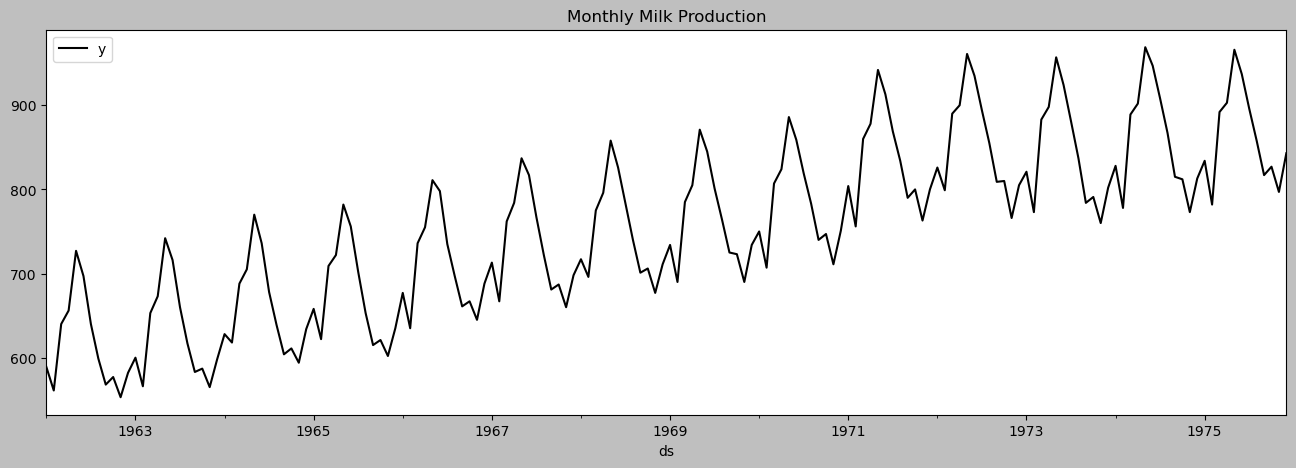

In [10]:
milk.set_index('ds').plot(title='Monthly Milk Production')

In [11]:
train.head()

ds    y
0 1962-01-01  589
1 1962-02-01  561
2 1962-03-01  640
3 1962-04-01  656
4 1962-05-01  727

In [19]:
model = Prophet(seasonality_mode='multiplicative').fit(train)

16:36:58 - cmdstanpy - INFO - Chain [1] start processing
16:36:58 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
model.seasonalities

OrderedDict([('yearly',
              {'period': 365.25,
               'fourier_order': 10,
               'prior_scale': 10.0,
               'mode': 'multiplicative',
               'condition_name': None})])

In [21]:
model.seasonalities

OrderedDict([('yearly',
              {'period': 365.25,
               'fourier_order': 10,
               'prior_scale': 10.0,
               'mode': 'multiplicative',
               'condition_name': None})])

In [22]:
model.uncertainty_samples

1000

In [23]:
model.component_modes

{'additive': ['additive_terms', 'extra_regressors_additive'],
 'multiplicative': ['yearly',
  'multiplicative_terms',
  'extra_regressors_multiplicative',
  'holidays']}

In [24]:
future = model.make_future_dataframe(len(test), freq='MS')

In [25]:
future

ds
0   1962-01-01
1   1962-02-01
2   1962-03-01
3   1962-04-01
4   1962-05-01
..         ...
163 1975-08-01
164 1975-09-01
165 1975-10-01
166 1975-11-01
167 1975-12-01

[168 rows x 1 columns]

In [26]:
len(milk) == len(future)

True

In [27]:
future.shape

(168, 1)

In [28]:
print(future.tail())

            ds
163 1975-08-01
164 1975-09-01
165 1975-10-01
166 1975-11-01
167 1975-12-01


In [29]:
forecast = model.predict(future)

In [30]:
forecast.columns.tolist()

['ds',
 'trend',
 'yhat_lower',
 'yhat_upper',
 'trend_lower',
 'trend_upper',
 'multiplicative_terms',
 'multiplicative_terms_lower',
 'multiplicative_terms_upper',
 'yearly',
 'yearly_lower',
 'yearly_upper',
 'additive_terms',
 'additive_terms_lower',
 'additive_terms_upper',
 'yhat']

In [31]:
cols = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']

In [32]:
forecast[cols].head()

ds        yhat  yhat_lower  yhat_upper
0 1962-01-01  591.551374  579.996997  603.210931
1 1962-02-01  559.591360  548.172792  571.237473
2 1962-03-01  636.733627  625.049515  647.820849
3 1962-04-01  651.326650  639.649405  663.345889
4 1962-05-01  702.961224  691.492666  714.982255

In [33]:
pd.concat([forecast['yhat'].iloc[0:5], train['y'].iloc[0:5]], axis=1)

yhat    y
0  591.551374  589
1  559.591360  561
2  636.733627  640
3  651.326650  656
4  702.961224  727

In [34]:
pd.concat([forecast['yhat'].iloc[-5:], test['y'].iloc[-5:]], axis=1)

yhat    y
163  851.880244  858
164  802.805495  817
165  807.277448  827
166  770.225331  797
167  810.243123  843

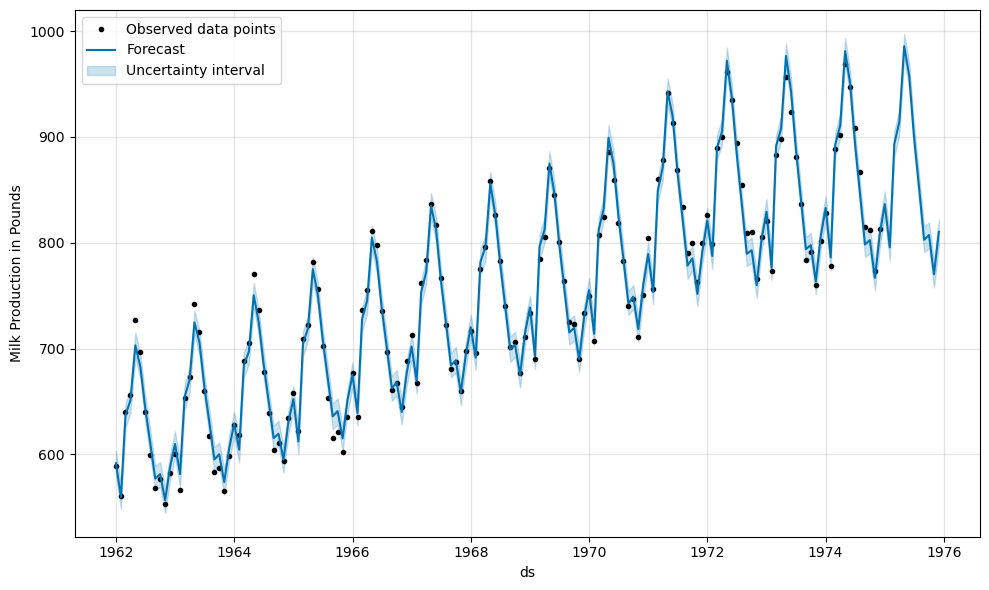

In [35]:
model.plot(forecast, 
           ylabel='Milk Production in Pounds',
           include_legend=True);

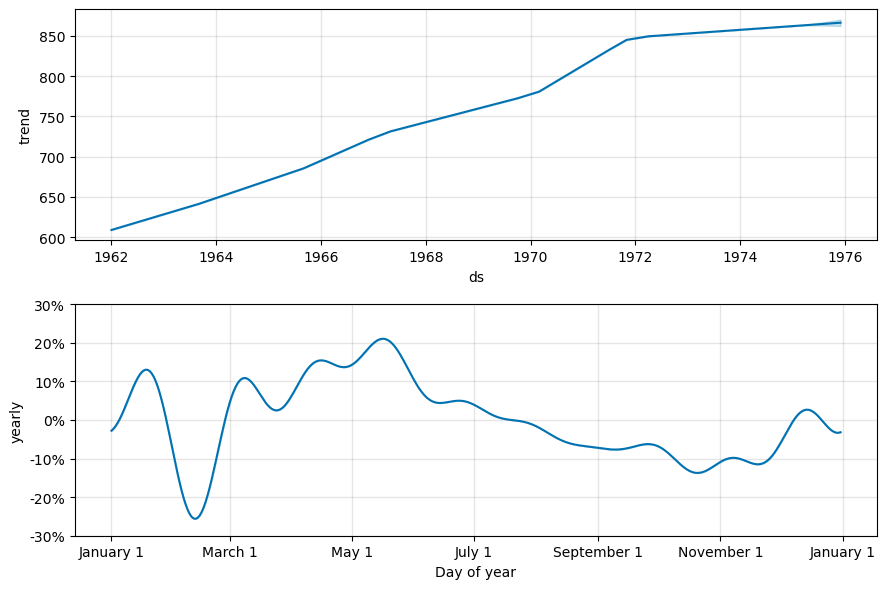

In [36]:
model.plot_components(forecast);

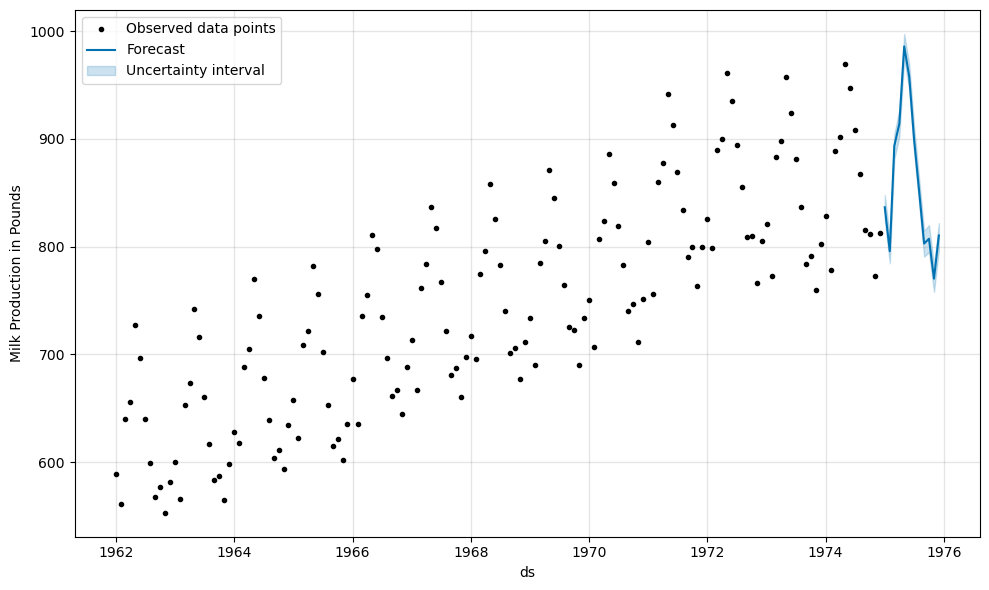

In [37]:
predicted = model.predict(test)
model.plot(predicted, 
           ylabel='Milk Production in Pounds',
          include_legend=True);

In [38]:
predicted.shape

(12, 16)

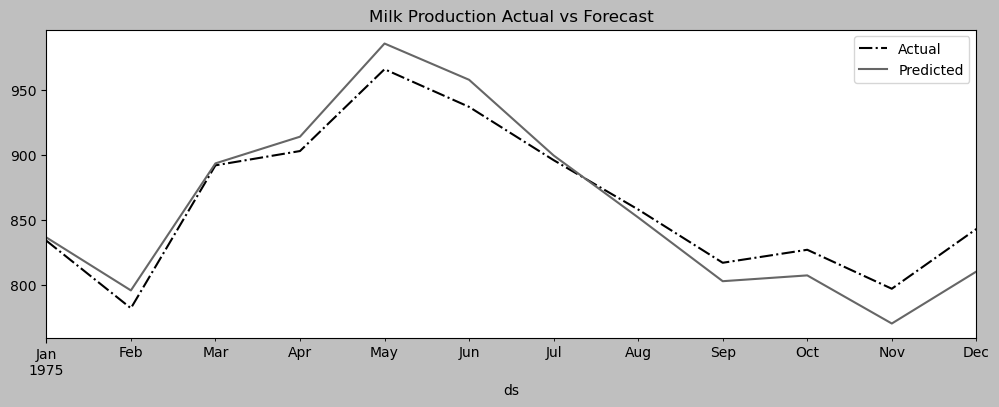

In [39]:
ax = test.plot(x='ds', y='y', 
                    label='Actual', 
                    style='-.', 
                    figsize=(12,4))

predicted.plot(x='ds', y='yhat', 
               label='Predicted', 
               ax=ax,
               title='Milk Production Actual vs Forecast');

### How it works


In [40]:
model.changepoints.shape

(25,)

In [41]:
model.changepoints.head()

5    1962-06-01
10   1962-11-01
15   1963-04-01
20   1963-09-01
25   1964-02-01
Name: ds, dtype: datetime64[ns]

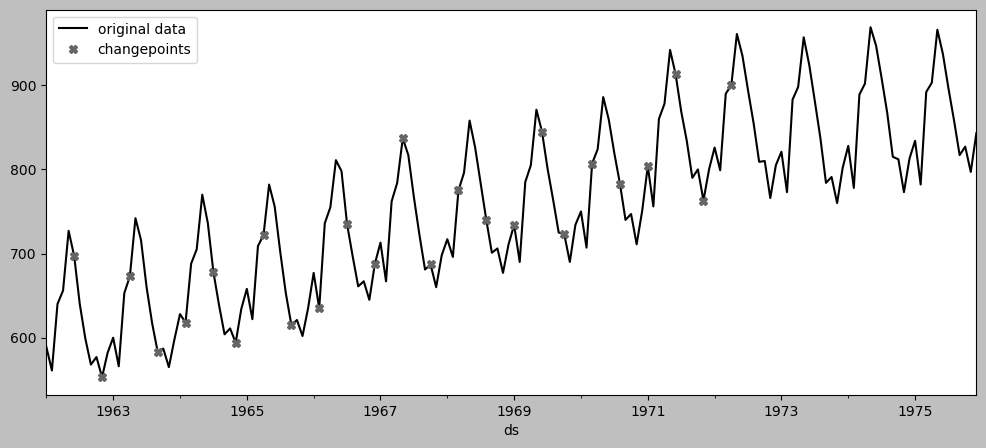

In [42]:
ax = milk.set_index('ds').plot(figsize=(12,5))
milk.set_index('ds').loc[model.changepoints].plot(style='X', ax=ax)
plt.legend(['original data', 'changepoints']);

### There is more

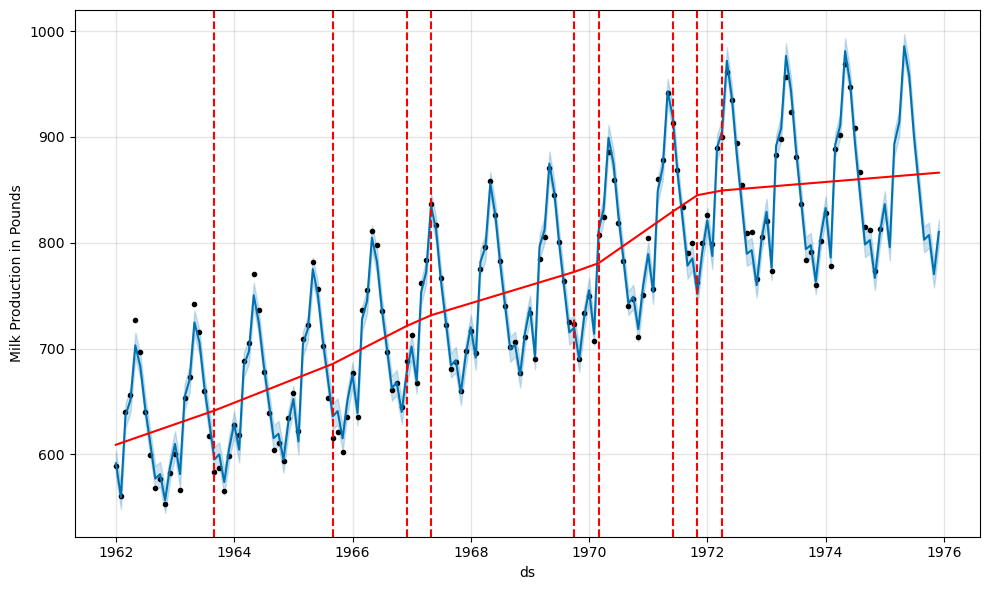

In [43]:
from prophet.plot import add_changepoints_to_plot

fig = model.plot(forecast, ylabel='Milk Production in Pounds')
add_changepoints_to_plot(fig.gca(), model, forecast);

In [44]:
from prophet.diagnostics import cross_validation, performance_metrics

# Cross-validation over the last 12 months
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')

# View the cross-validation results
df_cv.head()


  0%|                                                                                                                                                                                                                  | 0/21 [00:00<?, ?it/s]16:38:27 - cmdstanpy - INFO - Chain [1] start processing
16:38:35 - cmdstanpy - INFO - Chain [1] done processing
  5%|█████████▌                                                                                                                                                                                                | 1/21 [00:07<02:39,  7.98s/it]16:38:35 - cmdstanpy - INFO - Chain [1] start processing
16:38:35 - cmdstanpy - INFO - Chain [1] done processing
 10%|███████████████████▏                                                                                                                                                                                      | 2/21 [00:08<01:04,  3.40s/it]16:38:35 - cmdstanpy - INFO - Chain [1] start processing
16:

ds        yhat  yhat_lower  yhat_upper    y     cutoff
0 1964-02-01  577.415593  577.020650  577.882082  618 1964-01-23
1 1964-03-01  663.573441  661.987977  665.243013  688 1964-01-23
2 1964-04-01  684.320695  681.120289  687.633452  705 1964-01-23
3 1964-05-01  765.177927  759.406908  771.174385  770 1964-01-23
4 1964-06-01  723.286075  715.359007  731.140159  736 1964-01-23

In [45]:
print(df_cv.head())

          ds        yhat  yhat_lower  yhat_upper    y     cutoff
0 1964-02-01  577.415593  577.020650  577.882082  618 1964-01-23
1 1964-03-01  663.573441  661.987977  665.243013  688 1964-01-23
2 1964-04-01  684.320695  681.120289  687.633452  705 1964-01-23
3 1964-05-01  765.177927  759.406908  771.174385  770 1964-01-23
4 1964-06-01  723.286075  715.359007  731.140159  736 1964-01-23


In [46]:
df_p = performance_metrics(df_cv)
print(df_p.iloc[: , 0:-1].head())

  horizon         mse       rmse        mae      mape     mdape     smape
0 38 days  326.323160  18.064417  14.404974  0.019592  0.016023  0.019732
1 41 days  321.017196  17.916953  14.146961  0.019301  0.015046  0.019434
2 42 days  328.574321  18.126619  14.290525  0.019574  0.014644  0.019723
3 43 days  263.600103  16.235766  12.857889  0.017216  0.012411  0.017275
4 46 days  277.963628  16.672241  13.447809  0.017994  0.014644  0.018068


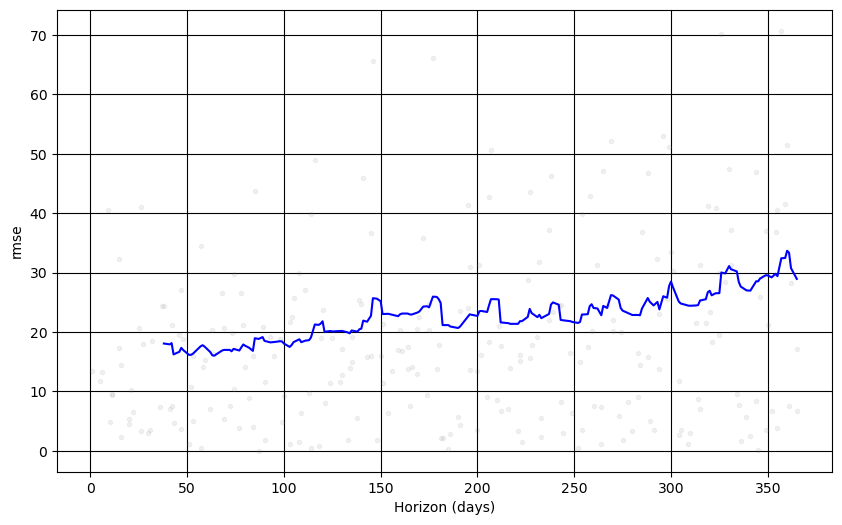

In [47]:
from prophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv, metric='rmse');


#  Recipe 2: Time Series Forecasting with Theta 

In [5]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
milk_file = Path('../../datasets/Ch11/milk_production.csv')
milk = pd.read_csv(milk_file, 
                   parse_dates=['month'], 
                   index_col='month')
milk.head()

production
month                 
1962-01-01         589
1962-02-01         561
1962-03-01         640
1962-04-01         656
1962-05-01         727

In [6]:
test_split = 12
train, test = split_data(milk, test_split)

print(f'Train: {train.shape}')
print(f'Test: {test.shape}')

train: 156 , test: 12
Train: (156, 1)
Test: (12, 1)


<Axes: xlabel='month'>

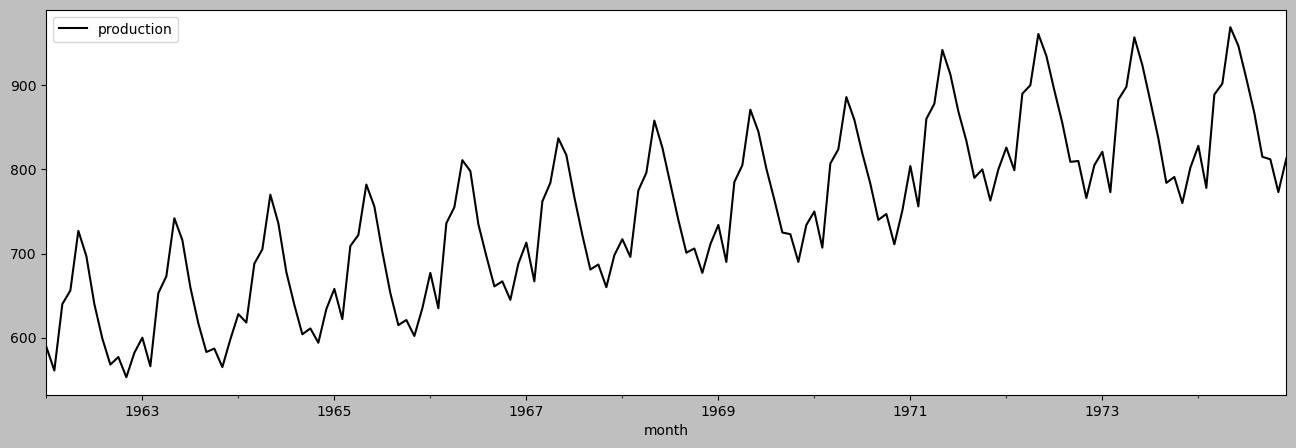

In [7]:
train.plot()

In [8]:
from statsmodels.tsa.forecasting.theta import ThetaModel

In [9]:
model = ThetaModel(train,
                  deseasonalize=True)

In [10]:
results = model.fit()

In [11]:
print(results.summary())

                              ThetaModel Results                              
Dep. Variable:             production   No. Observations:                  156
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Sat, 12 Oct 2024   Deseas. Method:         Multiplicative
Time:                        16:51:36   Period:                             12
Sample:                    01-01-1962                                         
                         - 12-01-1974                                         
  Parameter Estimates   
          Parameters    
------------------------
b0    1.8208359090694588
alpha  0.999793406347824
------------------------


In [12]:
results.params

b0       1.820836
alpha    0.999793
dtype: float64

In [13]:
n = test.shape[0]
intervals = results.prediction_intervals(steps=n, theta=2)
intervals

lower        upper
157  754.502242   931.025494
158  673.763431   923.405012
159  753.286268  1059.033514
160  748.579355  1101.625866
161  798.795498  1193.513497
162  748.562726  1180.954631
163  672.471537  1139.508172
164  606.607355  1105.890520
165  543.633581  1073.203348
166  534.840717  1093.056266
167  487.294533  1072.755939
168  517.549715  1129.044212

In [14]:
components = results.forecast_components(steps=n)
print(components)

         trend        ses  seasonal
157   1.821212  862.63851  0.975930
158   3.642048  862.63851  0.923796
159   5.462884  862.63851  1.047136
160   7.283720  862.63851  1.067902
161   9.104556  862.63851  1.148714
162  10.925392  862.63851  1.111344
163  12.746228  862.63851  1.042552
164  14.567064  862.63851  0.984282
165  16.387899  862.63851  0.928328
166  18.208735  862.63851  0.933702
167  20.029571  862.63851  0.893855
168  21.850407  862.63851  0.942458


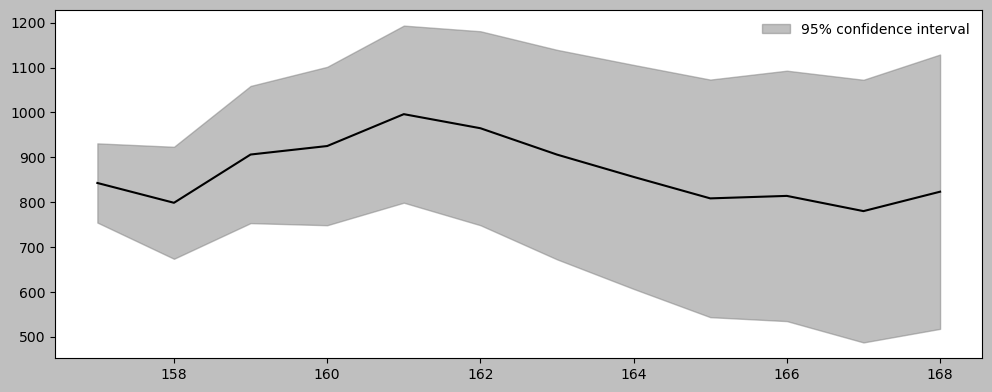

In [15]:
results.plot_predict(steps=n, theta=2, figsize=(10,4));

In [16]:
test.index

DatetimeIndex(['1975-01-01', '1975-02-01', '1975-03-01', '1975-04-01',
               '1975-05-01', '1975-06-01', '1975-07-01', '1975-08-01',
               '1975-09-01', '1975-10-01', '1975-11-01', '1975-12-01'],
              dtype='datetime64[ns]', name='month', freq=None)

In [17]:
forecast = results.forecast(steps=n, theta=2)
forecast_df = pd.Series(forecast.tolist(), index=test.index)
print(forecast_df)

month
1975-01-01    842.763868
1975-02-01    798.584222
1975-03-01    906.159891
1975-04-01    925.102611
1975-05-01    996.154497
1975-06-01    964.758678
1975-07-01    905.989855
1975-08-01    856.248938
1975-09-01    808.418465
1975-10-01    813.948492
1975-11-01    780.025236
1975-12-01    823.296964
dtype: float64


In [18]:
# test.plot()

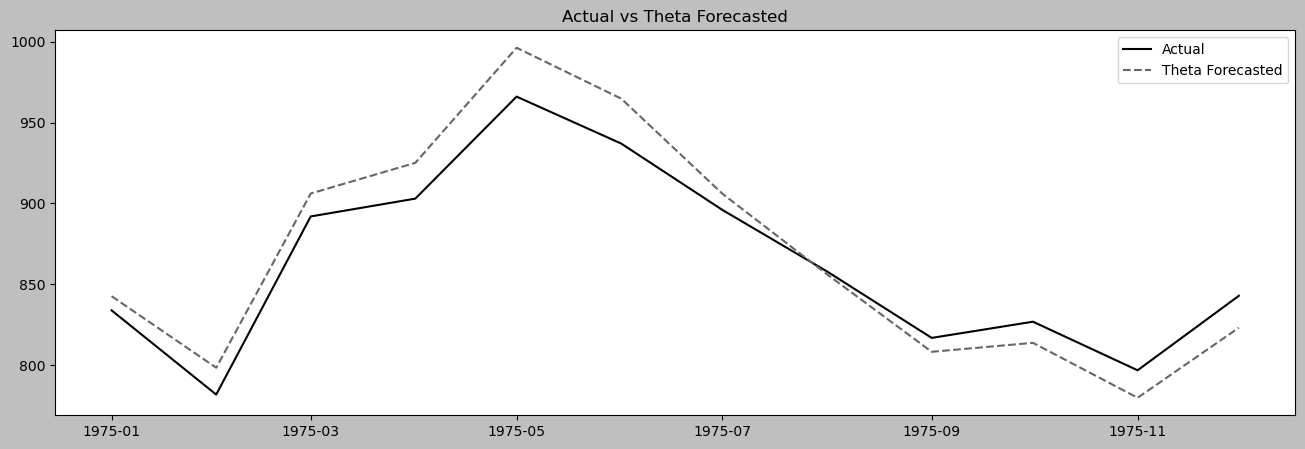

In [19]:
idx = test.index
plt.plot(idx, test['production'], label='Actual')
plt.plot(idx, forecast_df, label='Theta Forecasted', linestyle='dashed')
plt.title('Actual vs Theta Forecasted')
plt.legend()
plt.show()

# Recipe 3. Forecasting Multivariate Time Series Data using VAR

**VAR(1) Formula Example**
$$
\Large y_{(1),t} = \alpha_{1} + \theta_{11}y_{(1),t-1} + \theta_{12}y_{(2), t-1} + \epsilon_{(1),t} \\\Large y_{(2),t} = \alpha_{2} + \theta_{21}y_{(1),t-1} + \theta_{22}y_{(2),t-1} + \epsilon_{(2),t} 
\\~\\
\\~\\
\Large \begin{bmatrix} y_{(1),t} \\ y_{(2),t} \end{bmatrix} =
\Large \begin{bmatrix} \alpha_{1} \\ \alpha_{2} \end{bmatrix} + \begin{bmatrix} \theta_{11} & \theta_{12} \\ \theta_{21} &  \theta_{22} \end{bmatrix}  \begin{bmatrix} y_{(1),t-1} \\ y_{(2), t-1} \end{bmatrix} + \begin{bmatrix} \epsilon_{(1),t} \\ \epsilon_{(2),t} \end{bmatrix}
$$

In [ ]:
FRED = "1688936085986f7d384342a6507227e1"

In [5]:
from statsmodels.tsa.api import VAR,adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('grayscale')

In [6]:
import statsmodels as sm
import matplotlib as mp

In [7]:
import pandas_datareader.data as web
start = "01-01-1990"
end = "01-09-2024"
economic_df = web.FredReader(
        symbols=["FEDFUNDS", "unrate"], 
        start=start,
        end=end).read()

#you can store the file for future reference (uncomment below)
file = '../../datasets/Ch11/economic_df.pickle'
# economic_df.to_pickle(file)
economic_df = pd.read_pickle(file)

In [8]:
economic_df.to_csv('../../datasets/Ch11/economic_df.csv', index=True)

In [9]:
economic_df.head()

FEDFUNDS  unrate
DATE                        
1990-01-01      8.23     5.4
1990-02-01      8.24     5.3
1990-03-01      8.28     5.2
1990-04-01      8.26     5.4
1990-05-01      8.18     5.4

In [10]:
economic_df.tail()

FEDFUNDS  unrate
DATE                        
2024-05-01      5.33     4.0
2024-06-01      5.33     4.1
2024-07-01      5.33     4.3
2024-08-01      5.33     4.2
2024-09-01      5.13     4.1

In [11]:
economic_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 417 entries, 1990-01-01 to 2024-09-01
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FEDFUNDS  417 non-null    float64
 1   unrate    417 non-null    float64
dtypes: float64(2)
memory usage: 9.8 KB


In [12]:
economic_df.index.freq = 'MS'

In [13]:
economic_df.index

DatetimeIndex(['1990-01-01', '1990-02-01', '1990-03-01', '1990-04-01',
               '1990-05-01', '1990-06-01', '1990-07-01', '1990-08-01',
               '1990-09-01', '1990-10-01',
               ...
               '2023-12-01', '2024-01-01', '2024-02-01', '2024-03-01',
               '2024-04-01', '2024-05-01', '2024-06-01', '2024-07-01',
               '2024-08-01', '2024-09-01'],
              dtype='datetime64[ns]', name='DATE', length=417, freq='MS')

In [14]:
economic_df.isna().sum()

FEDFUNDS    0
unrate      0
dtype: int64

In [15]:
economic_df.shape

(417, 2)

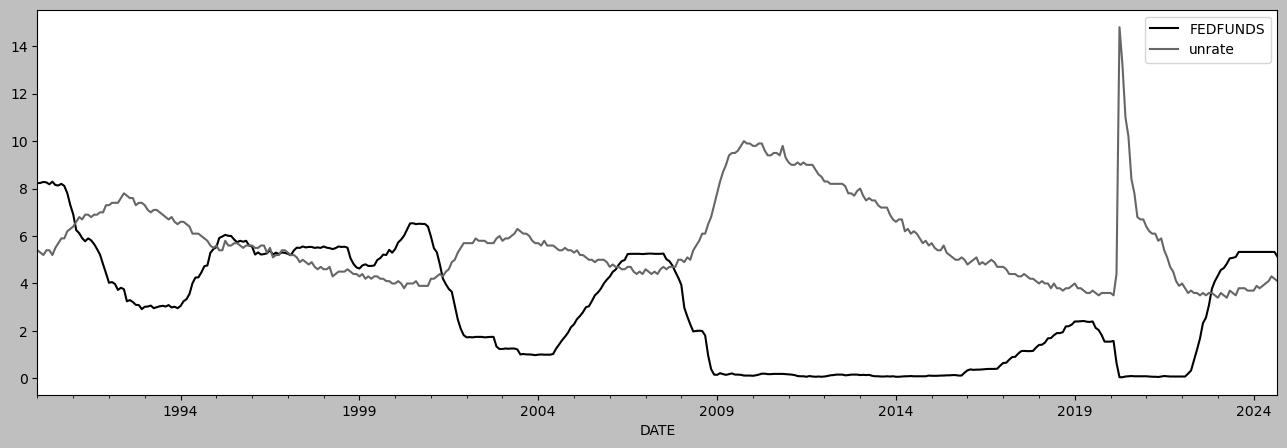

In [21]:
economic_df.plot();

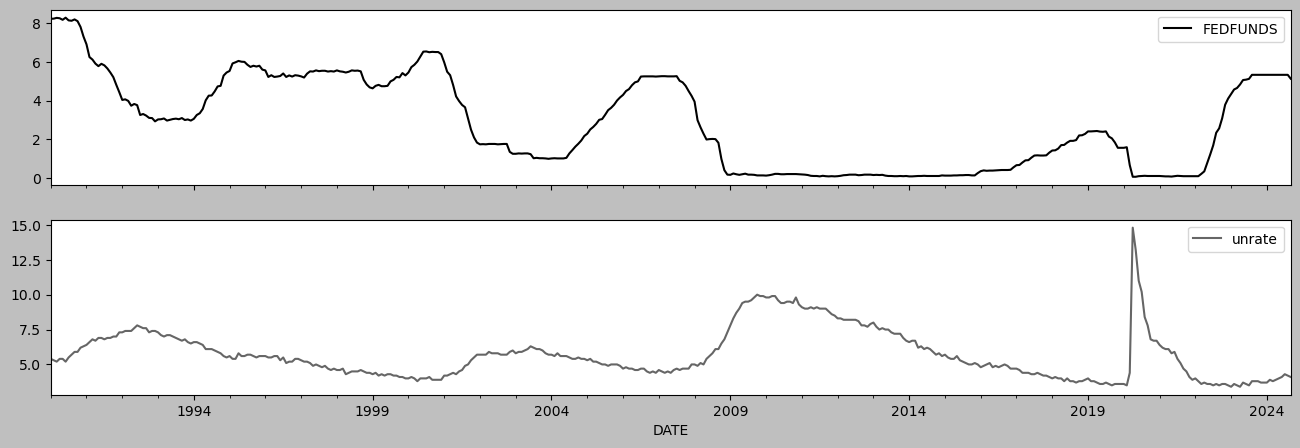

In [22]:
economic_df.plot(subplots=True);

In [23]:
correlation_matrix = economic_df.corr()
print(correlation_matrix)

          FEDFUNDS    unrate
FEDFUNDS  1.000000 -0.435171
unrate   -0.435171  1.000000


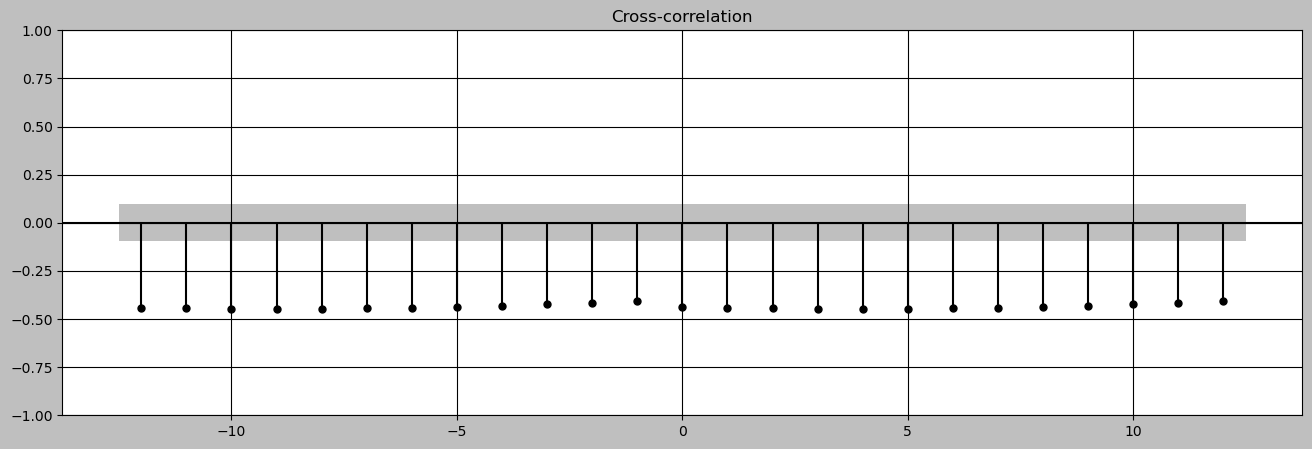

In [24]:
from statsmodels.graphics.tsaplots import ccf, plot_ccf
import numpy as np

# Calculate the cross-correlation between FEDFUNDS and unrate
lags = np.arange(-12, 13)  # Limiting the lag to 12 months ahead and behind for better interpretability
cross_corr_values = ccf(economic_df['FEDFUNDS'], economic_df['unrate'])

# Plot the cross-correlation function
# plt.figure(figsize=(10, 6))
# plt.stem(lags, cross_corr_values[:len(lags)], use_line_collection=True)
# plt.title('Cross-Correlation Function between FEDFUNDS and Unrate')
# plt.xlabel('Lag')
# plt.ylabel('Cross-Correlation')
# plt.grid(True)
# plt.show()
#plt.figure(figsize=(10, 5))
plot_ccf(economic_df['FEDFUNDS'], economic_df['unrate'], lags=lags)
plt.grid(True)

In [25]:
# import matplotlib.pyplot as plt
# from statsmodels.graphics.tsaplots import plot_ccf

# # Adjust figure size and styling
# plt.figure(figsize=(10, 5))
# plt.style.use('default')  # Reset to a cleaner style

# # Plot the CCF with better formatting
# plot_ccf(economic_df['FEDFUNDS'], economic_df['unrate'], lags=np.arange(-12, 13))
# plt.grid(True)
# plt.show()


In [26]:
# def check_stationarity(df):
#     kps = kpss(df)
#     adf = adfuller(df)
    
#     kpss_pv, adf_pv = kps[1], adf[1]
#     kpssh, adfh = 'Stationary', 'Non-stationary'
    
#     if adf_pv < 0.05:
#         # Reject ADF Null Hypothesis
#         adfh = 'Stationary'
#     if kpss_pv < 0.05:
#         # Reject KPSS Null Hypothesis
#         kpssh = 'Non-stationary'
#     return (kpssh, adfh)

In [28]:
from statsmodels.tsa.stattools import adfuller
# def check_stationarity(series):
#     # KPSS Test (with 'ct' for trend; can use 'c' for constant only)
#     kpss_stat, kpss_p_value, *_ = kpss(series, regression='c', nlags="auto")
    
#     # ADF Test (with default lag structure)
#     adf_stat, adf_p_value, *_ = adfuller(series)
    
#     # Interpreting results
#     adf_result = 'Stationary' if adf_p_value < 0.05 else 'Non-stationary'
#     kpss_result = 'Non-stationary' if kpss_p_value < 0.05 else 'Stationary'
    
#     return {'ADF': adf_result, 'KPSS': kpss_result}

# # Applying the check_stationarity function to each time series column
# for col in economic_df.columns:
#     results = check_stationarity(economic_df[col])
#     print(f'{col} ADF: {results["ADF"]}, KPSS: {results["KPSS"]}')


In [29]:
def check_stationarity(df):
    adf_pv = adfuller(df)[1]
    result = 'Stationary' if adf_pv < 0.05 else "Non-Stationary"
    return result

In [30]:
# check_stationarity(economic_df['FEDFUNDS'].diff().dropna())
check_stationarity(economic_df['FEDFUNDS'])

'Stationary'

In [31]:
for i in economic_df:
    adf = check_stationarity(economic_df[i])
    print(f'{i} adf: {adf}')

FEDFUNDS adf: Stationary
unrate adf: Stationary


The data for testing whether the time series in the second column Granger
causes the time series in the first column. Missing values are not
supported.

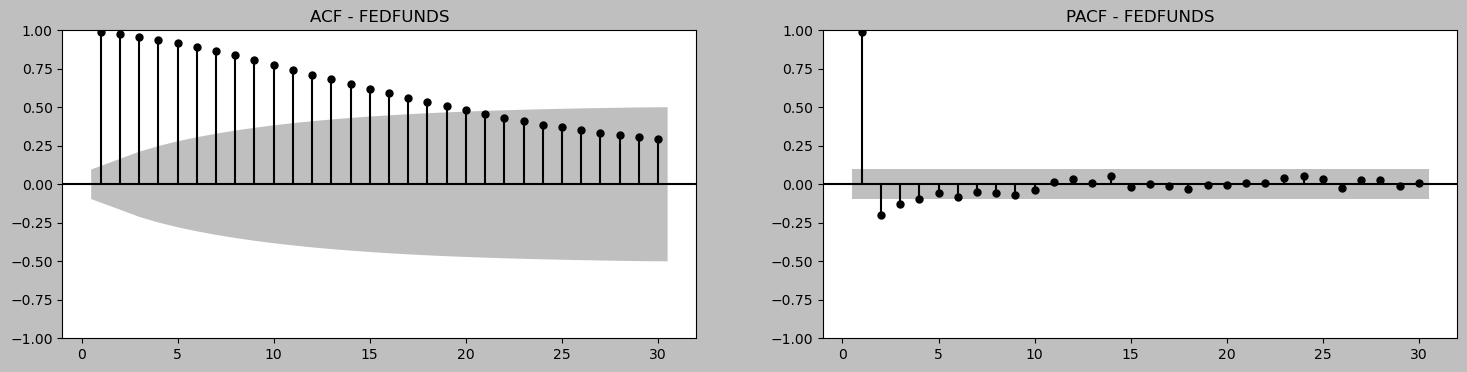

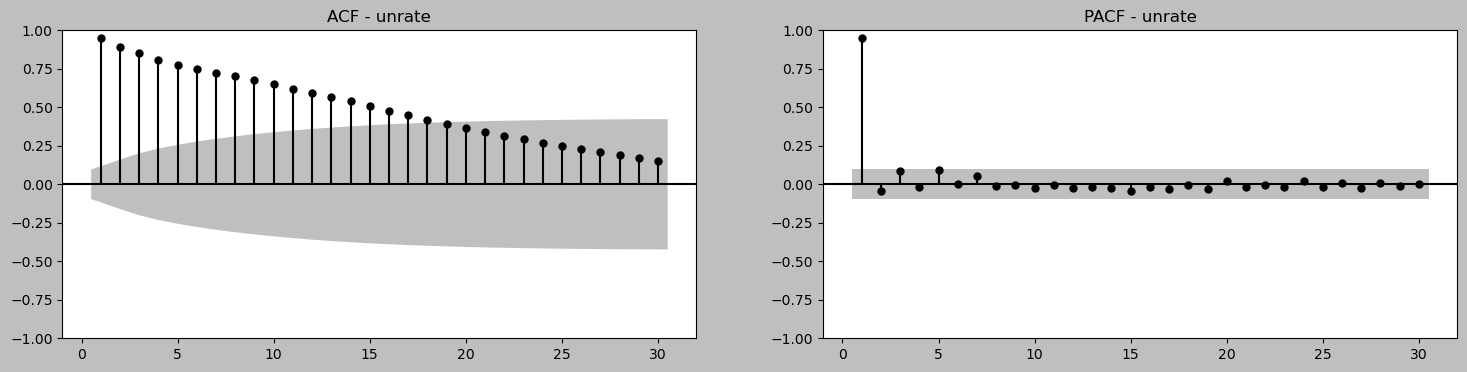

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
for col in economic_df.columns:
    fig, ax = plt.subplots(1,2, figsize=(18,4))
    plot_acf(economic_df[col], zero=False, 
             lags=30, ax=ax[0], title=f'ACF - {col}')
    plot_pacf(economic_df[col], zero=False, 
              lags=30, ax=ax[1], title=f'PACF - {col}');

In [33]:
train = economic_df.loc[:'2022']
test = economic_df.loc['2023':]

In [34]:
train.index

DatetimeIndex(['1990-01-01', '1990-02-01', '1990-03-01', '1990-04-01',
               '1990-05-01', '1990-06-01', '1990-07-01', '1990-08-01',
               '1990-09-01', '1990-10-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', name='DATE', length=396, freq='MS')

In [35]:
test.index

DatetimeIndex(['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
               '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',
               '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01',
               '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01',
               '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01',
               '2024-09-01'],
              dtype='datetime64[ns]', name='DATE', freq='MS')

In [36]:
print(f'Train: {len(train)}, Test: {len(test)}')

Train: 396, Test: 21


In [37]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
scale.fit(train)
train_sc = pd.DataFrame(scale.transform(train),
                        index=train.index,
                        columns=train.columns)
test_sc = pd.DataFrame(scale.transform(test), 
                       index=test.index,
                       columns=test.columns)

In [38]:
test[0:5]

FEDFUNDS  unrate
DATE                        
2023-01-01      4.33     3.4
2023-02-01      4.57     3.6
2023-03-01      4.65     3.5
2023-04-01      4.83     3.4
2023-05-01      5.06     3.7

In [39]:
scale.inverse_transform(test_sc)[0:5]

array([[4.33, 3.4 ],
       [4.57, 3.6 ],
       [4.65, 3.5 ],
       [4.83, 3.4 ],
       [5.06, 3.7 ]])

<Axes: xlabel='DATE'>

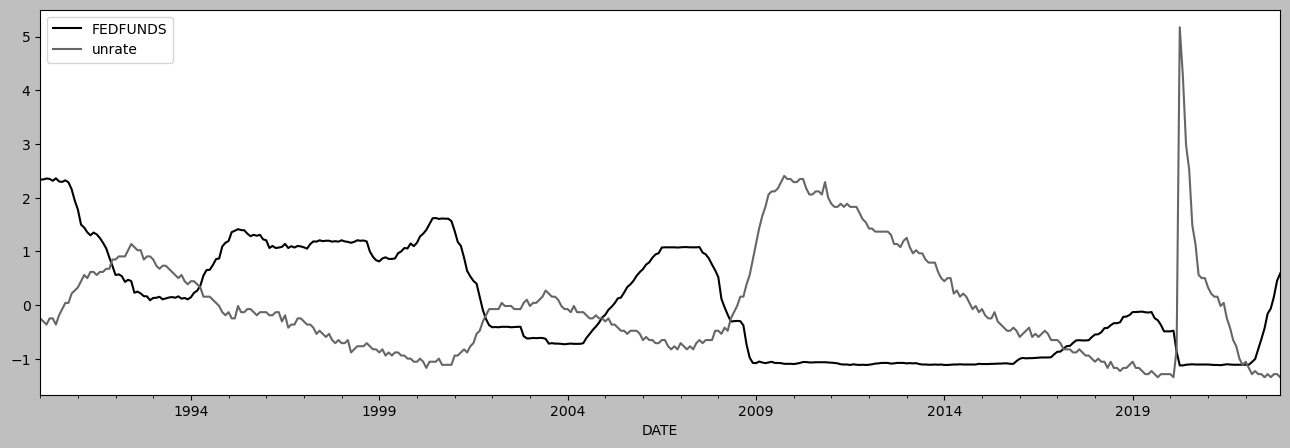

In [40]:
train_sc.plot()

In [41]:
train_sc.shape

(396, 2)

In [42]:
test_sc.shape

(21, 2)

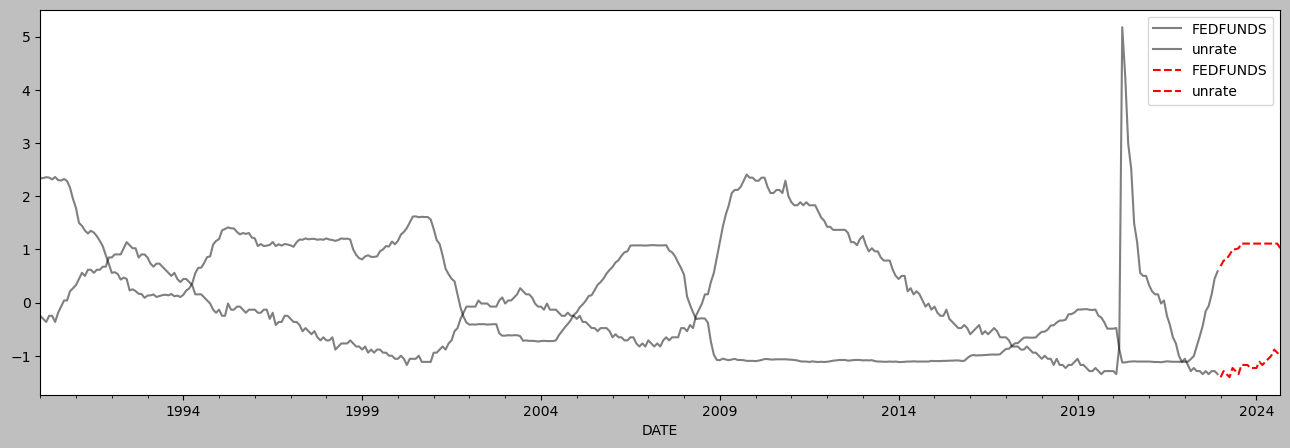

In [43]:
ax = train_sc.plot(style='k', alpha=0.5, label='train')
test_sc.plot(ax=ax, style='r--', label='test')
plt.legend(); plt.show()

In [44]:
model = VAR(endog=train_sc)
res = model.select_order(maxlags=10)
res.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [45]:
res

In [46]:
print(res.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0      -0.2862     -0.2657      0.7511     -0.2780
1       -7.345      -7.283   0.0006461      -7.320
2       -7.874      -7.772   0.0003805      -7.833
3       -7.960     -7.817*   0.0003491     -7.903*
4       -7.960      -7.775   0.0003492      -7.887
5       -7.951      -7.726   0.0003523      -7.862
6       -7.967      -7.701   0.0003467      -7.861
7      -7.974*      -7.667  0.0003443*      -7.852
8       -7.957      -7.609   0.0003502      -7.819
9       -7.947      -7.557   0.0003539      -7.792
10      -7.931      -7.501   0.0003593      -7.761
--------------------------------------------------


In [47]:
print(res.selected_orders)

{'aic': 7, 'bic': 3, 'hqic': 3, 'fpe': 7}


In [48]:
print(f'AIC: {res.aic} , BIC: {res.bic}, \
      HQ: {res.hqic}, FPE: {res.fpe}')

AIC: 7 , BIC: 3,       HQ: 3, FPE: 7


In [50]:
results = model.fit(ic='bic')

In [51]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 08, Oct, 2024
Time:                     12:14:21
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -7.83732
Nobs:                     393.000    HQIC:                  -7.92278
Log likelihood:           466.565    FPE:                0.000342624
AIC:                     -7.97888    Det(Omega_mle):     0.000330737
--------------------------------------------------------------------
Results for equation FEDFUNDS
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.000857         0.003027           -0.283           0.777
L1.FEDFUNDS         1.512010         0.050033           30.220           0.000
L1.unrate           0.022573         0.009688            2.330   

In [52]:
type(results)

statsmodels.tsa.vector_ar.var_model.VARResultsWrapper

In [53]:
lag_order = results.k_ar
lag_order

3

In [54]:
results.params

FEDFUNDS    unrate
const       -0.000857 -0.005764
L1.FEDFUNDS  1.512010 -2.031248
L1.unrate    0.022573  0.962183
L2.FEDFUNDS -0.311125  3.174268
L2.unrate   -0.014022 -0.079938
L3.FEDFUNDS -0.209903 -1.163390
L3.unrate   -0.010531  0.056060

In [55]:
train_sc[-lag_order:]

FEDFUNDS    unrate
DATE                          
2022-10-01  0.158507 -1.285284
2022-11-01  0.454585 -1.285284
2022-12-01  0.589935 -1.342971

<Axes: xlabel='DATE'>

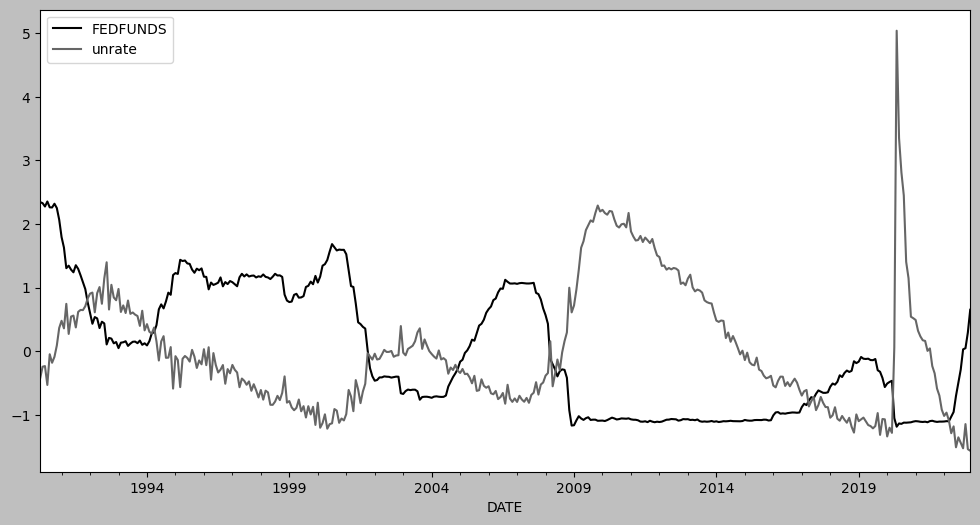

In [56]:
results.fittedvalues.plot(figsize=(12,6))

array([<Axes: xlabel='DATE'>, <Axes: xlabel='DATE'>], dtype=object)

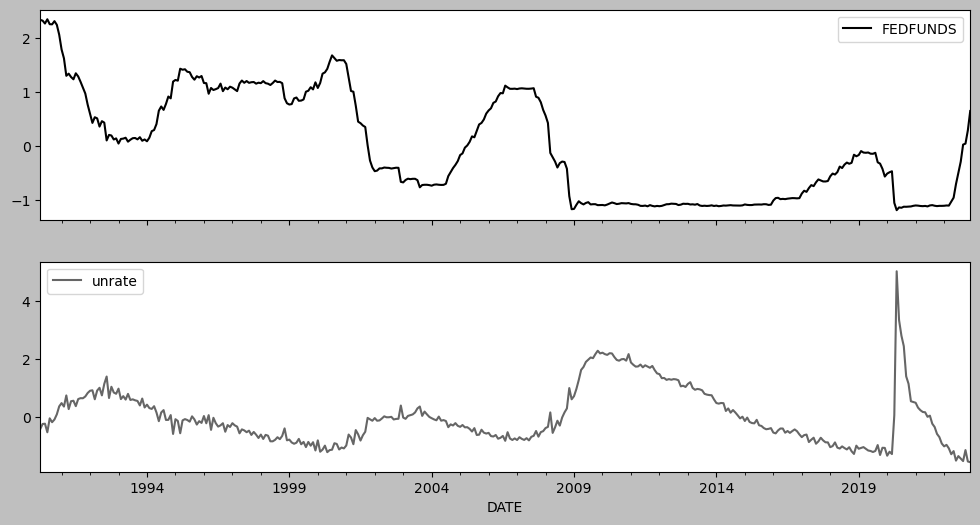

In [57]:
results.fittedvalues.plot(figsize=(12,6), subplots=True)

**Manually creating a similar plot**

In [58]:
past_y = train_sc[-lag_order:].values
n = test_sc.shape[0]
forecast, lower, upper = results.forecast_interval(y=past_y, steps=n)

In [59]:
forecast_df = pd.DataFrame(scale.inverse_transform(forecast), 
                           index=test_sc.index, 
                           columns=test_sc.columns)
lower_df = pd.DataFrame(scale.inverse_transform(lower), 
                        index=test_sc.index, 
                        columns=test_sc.columns)
upper_df = pd.DataFrame(scale.inverse_transform(upper), 
                        index=test_sc.index, 
                        columns=test_sc.columns)


In [ ]:
# forecast = scale.inverse_transform(forecast)
# lower = scale.inverse_transform(lower)
# upper = scale.inverse_transform(upper)

In [ ]:
# forecast_df = pd.DataFrame(forecast, index=test_sc.index, columns=test_sc.columns)
# pd.DataFrame(lower, index=test_sc.index, columns=test_sc.columns)



In [ ]:
# forecast, lower, upper = results.forecast_interval(past_y, steps=n)

# idx = test.index
# style = 'k--'
# ax = train_sc.iloc[:-lag_order, 1].plot(figsize=(10, 4), style='k')
# pred_forecast  = pd.Series(forecast[:, 1], index=idx).plot(ax=ax, style=style)
# pred_lower = pd.Series(lower[:, 1], index=idx).plot(ax=ax, style=style)
# pred_upper  = pd.Series(upper[:, 1], index=idx).plot(ax=ax, style=style)
# plt.title('Forecasting Unemployment Rate (unrate)')
# plt.show()

Alternatively you can also use `fill_between`

In [ ]:
# forecast, lower, upper = results.forecast_interval(past_y, steps=n)

# idx = test.index; style = 'k--'
# ax = train_sc.iloc[:-lag_order, 1].plot(style='k')
# pred_forecast  = pd.Series(forecast[:, 1], index=idx).plot(ax=ax, style=style)
# pred_lower = pd.Series(lower[:, 1], index=idx).plot(ax=ax, style=style)
# pred_upper  = pd.Series(upper[:, 1], index=idx).plot(ax=ax, style=style)
# plt.fill_between(idx, lower[:,1], upper[:,1], alpha=0.12)
# plt.title('Forecasting Unemployment Rate (unrate)')
# plt.legend(['Train','Forecast']);plt.show()


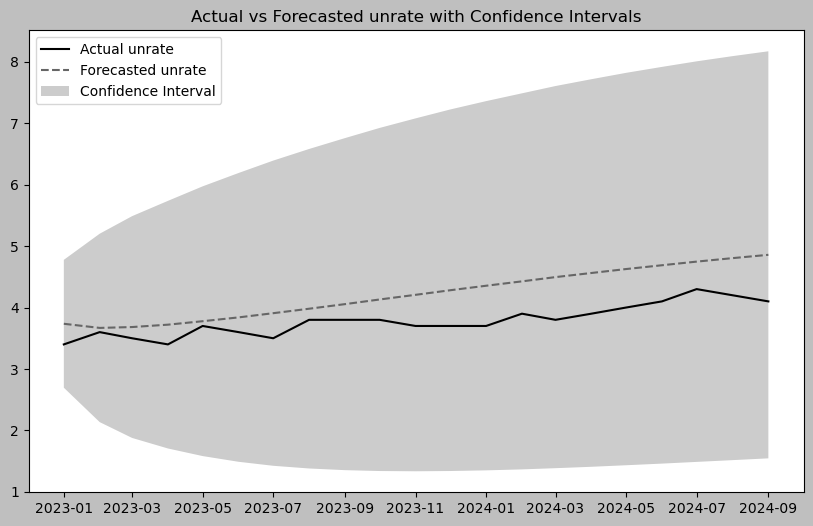

In [63]:
idx = test.index
plt.figure(figsize=(10, 6))
plt.plot(idx, test['unrate'], label='Actual unrate')
plt.plot(idx, forecast_df['unrate'], label='Forecasted unrate', linestyle='dashed')
plt.fill_between(idx, lower_df['unrate'], upper_df['unrate'], alpha=0.2, label='Confidence Interval')
plt.title('Actual vs Forecasted unrate with Confidence Intervals')
plt.legend()
plt.show()

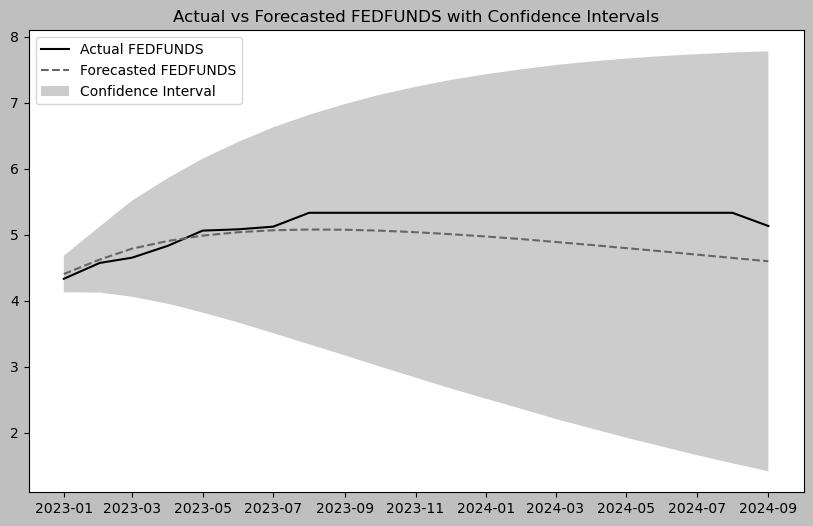

In [65]:
idx = test.index
plt.figure(figsize=(10, 6))
plt.plot(idx, test['FEDFUNDS'], label='Actual FEDFUNDS')
plt.plot(idx, forecast_df['FEDFUNDS'], label='Forecasted FEDFUNDS', linestyle='dashed')
plt.fill_between(idx, lower_df['FEDFUNDS'], upper_df['FEDFUNDS'], alpha=0.2, label='Confidence Interval')
plt.title('Actual vs Forecasted FEDFUNDS with Confidence Intervals')
plt.legend()
plt.show()

## There is more
* Comparing the results from VAR(3) with an AR(3) 
* AR(3) is a univariate this way we are comparing using one variable (unrate) to see if using two variables are better or not
* Using ARIMA(3, 0, 0) indicates an AR(3)

In [66]:
from statsmodels.tsa.arima.model import ARIMA
lag_order

3

In [67]:
model = ARIMA(train['unrate'], 
              order=(lag_order,0,0)).fit()

In [68]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 unrate   No. Observations:                  396
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -337.221
Date:                Tue, 08 Oct 2024   AIC                            684.441
Time:                        12:15:09   BIC                            704.348
Sample:                    01-01-1990   HQIC                           692.328
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7123      1.693      3.374      0.001       2.394       9.030
ar.L1          0.9945      0.024     40.795      0.000       0.947       1.042
ar.L2         -0.1355      0.042     -3.205      0.001      -0.218      -0.053
ar.L3          0.0879      0.035      2.542      0.011       0.020       0.156
sigma2         0.3197      0.008     38.756      0.000       0.304       0.336
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):           1245807.56
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):              37.61   Skew:                            15.04
Prob(H) (two-sided):                  0.00   Kurtosis:                       276.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

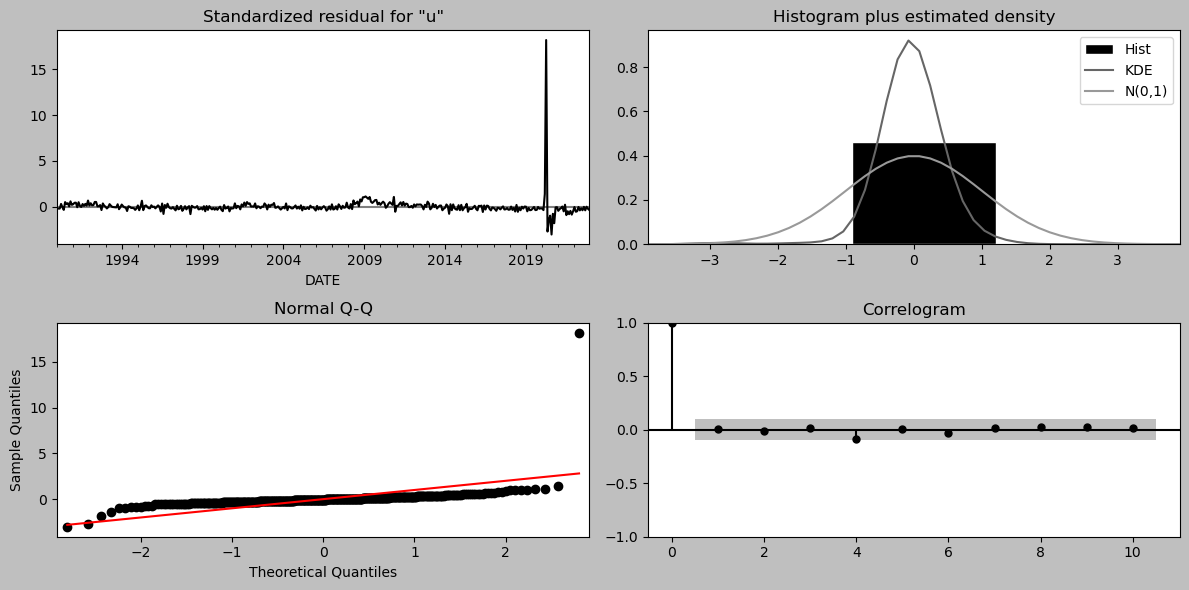

In [85]:
fig = model.plot_diagnostics(figsize=(12,6));
fig.tight_layout();plt.show()

In [70]:
ar_forecast = pd.Series(model.forecast(n), index=test.index)

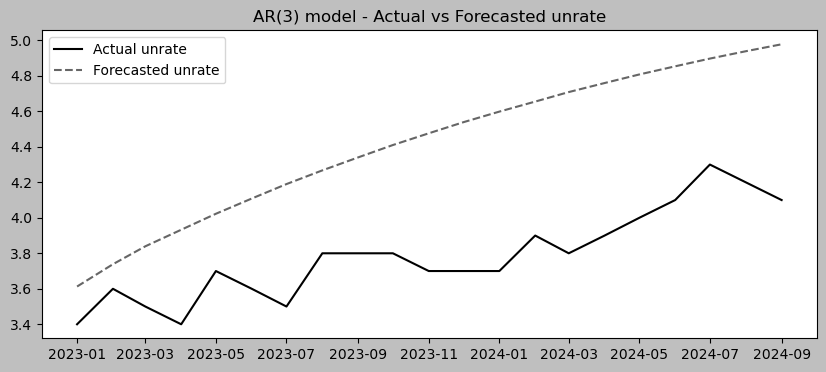

In [81]:
# Plotting the results from an AR(3)
idx = test.index
plt.figure(figsize=(10, 4))
plt.plot(idx, test['unrate'], label='Actual unrate')
plt.plot(idx, ar_forecast, label='Forecasted unrate', linestyle='dashed')
plt.title('AR(3) model - Actual vs Forecasted unrate')
plt.legend()
plt.show()
# plt.title('AR(3) Model - Forecast vs Actual')
# test['unrate'].plot(style='--', alpha=0.45, figsize=(12, 4))
# ar_forecast.plot()
# plt.legend(['test', 'Forecast']);

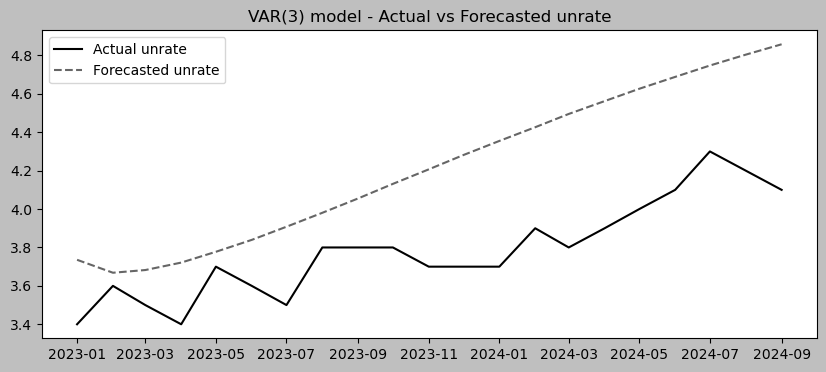

In [82]:
# plotting VAR(3) same code as before but without confidence intervals 
idx = test.index
plt.figure(figsize=(10, 4))
plt.plot(idx, test['unrate'], label='Actual unrate')
plt.plot(idx, forecast_df['unrate'], label='Forecasted unrate', linestyle='dashed')
plt.title('VAR(3) model - Actual vs Forecasted unrate')
plt.legend()
plt.show()

In [90]:
from statsmodels.tools.eval_measures import rmse
rmse_var = rmse(test['FEDFUNDS'], forecast_df['unrate'])
print('VAR(3) RMSE = ', rmse_var)

rmse_ar = rmse(test['FEDFUNDS'], ar_forecast)
print('AR(3) RMSE = ', rmse_ar)

VAR(3) RMSE =  0.9729655920788434
AR(3) RMSE =  0.7693416723850359


# Recipe 4. Evaluating vector autoregressive (VAR) models

In [96]:
# from statsmodels.tsa.api import VAR
# model = VAR(economic_df[['unrate', 'FEDFUNDS']])
# lag_order_selection = model.select_order(maxlags=12)
# print(lag_order_selection.summary())


In [98]:
granger = grangercausalitytests(
            x=economic_df[['unrate', 'FEDFUNDS']], 
            maxlag=3)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5680  , p=0.4515  , df_denom=413, df_num=1
ssr based chi2 test:   chi2=0.5721  , p=0.4494  , df=1
likelihood ratio test: chi2=0.5717  , p=0.4496  , df=1
parameter F test:         F=0.5680  , p=0.4515  , df_denom=413, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=21.9344 , p=0.0000  , df_denom=410, df_num=2
ssr based chi2 test:   chi2=44.4039 , p=0.0000  , df=2
likelihood ratio test: chi2=42.1852 , p=0.0000  , df=2
parameter F test:         F=21.9344 , p=0.0000  , df_denom=410, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=21.6694 , p=0.0000  , df_denom=407, df_num=3
ssr based chi2 test:   chi2=66.1262 , p=0.0000  , df=3
likelihood ratio test: chi2=61.3477 , p=0.0000  , df=3
parameter F test:         F=21.6694 , p=0.0000  , df_denom=407, df_num=3


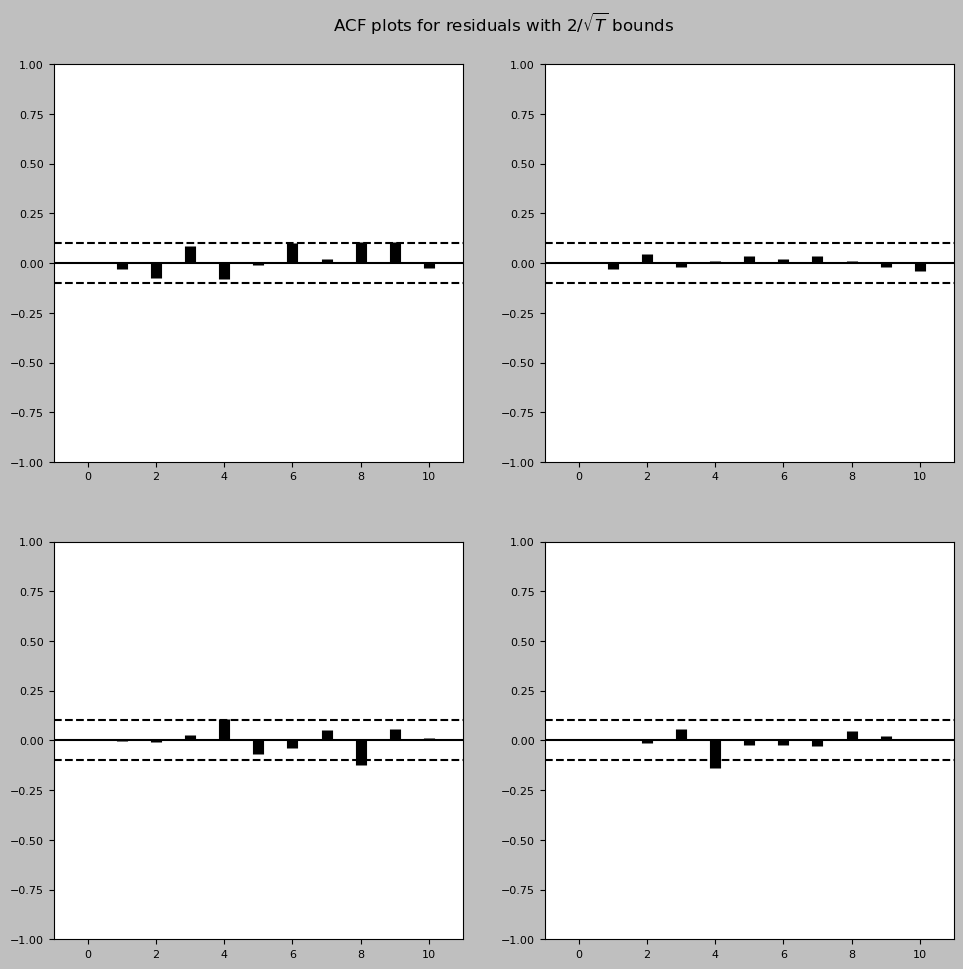

In [99]:
results.plot_acorr(resid=True);plt.show()

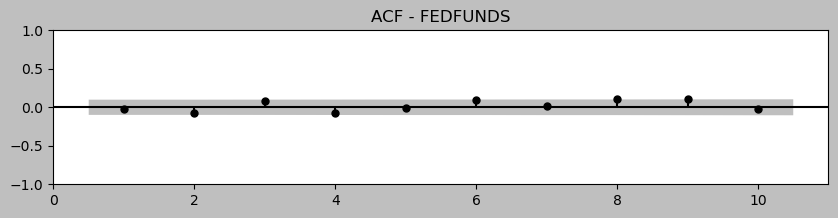

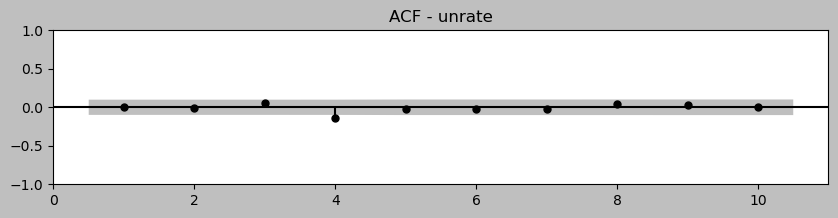

In [106]:
# You can plot your ACF on the resiuals as well using results.resid
for col in results.resid.columns:
    fig, ax = plt.subplots(1,1, figsize=(10,2))
    plot_acf(results.resid[col], zero=False, 
             lags=10, ax=ax, title=f'ACF - {col}')

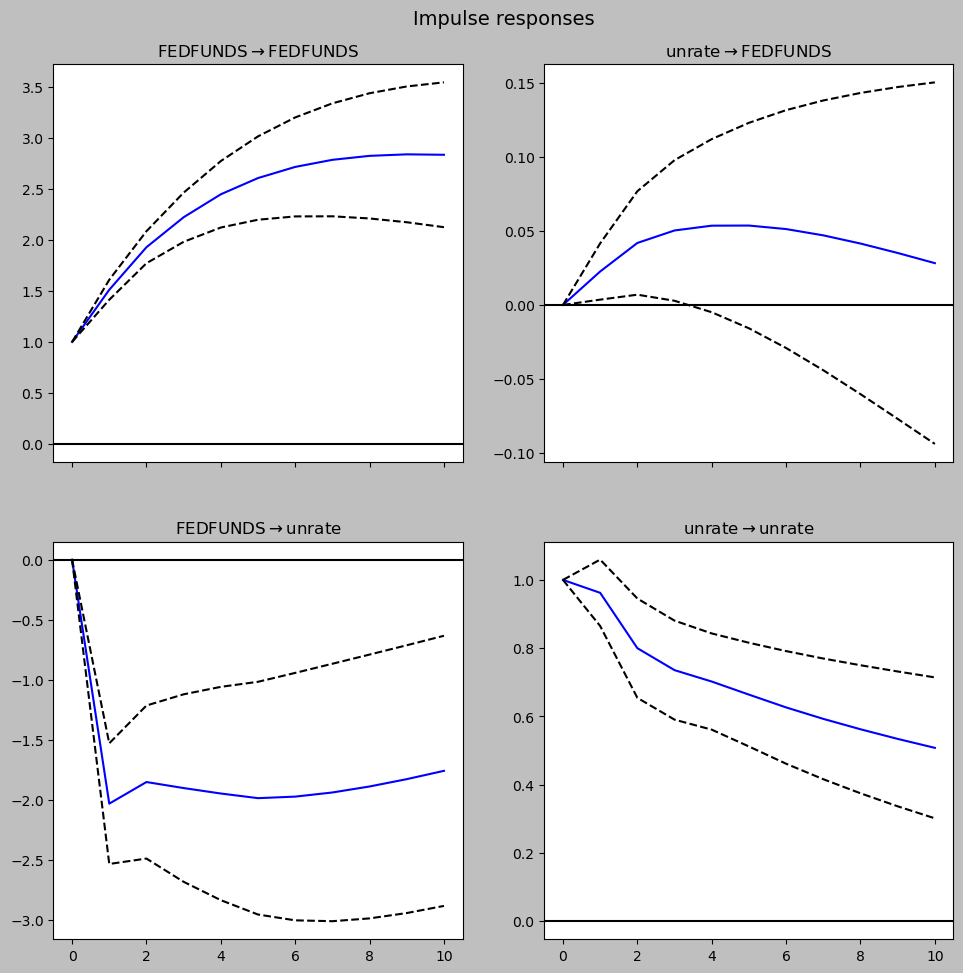

In [121]:
irf_output = results.irf()
irf_output.plot();

In [122]:
irf_output 

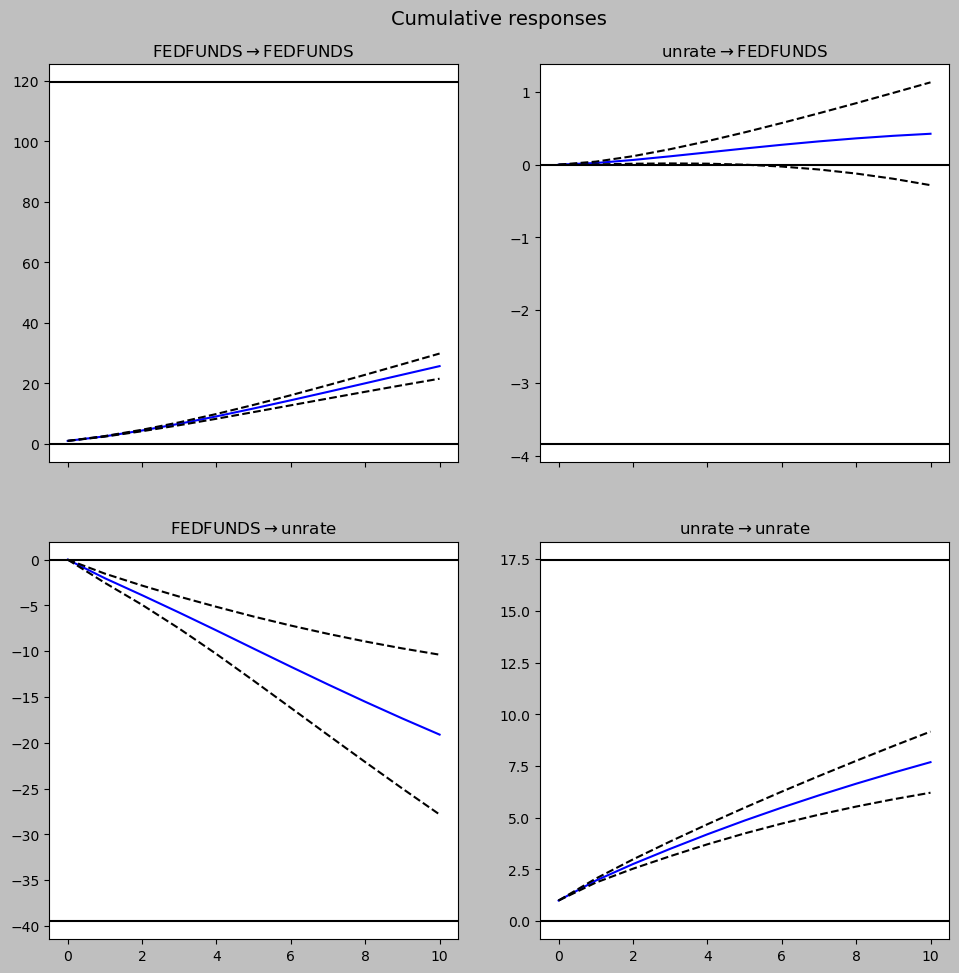

In [135]:
irf_output.plot_cum_effects()
plt.show()

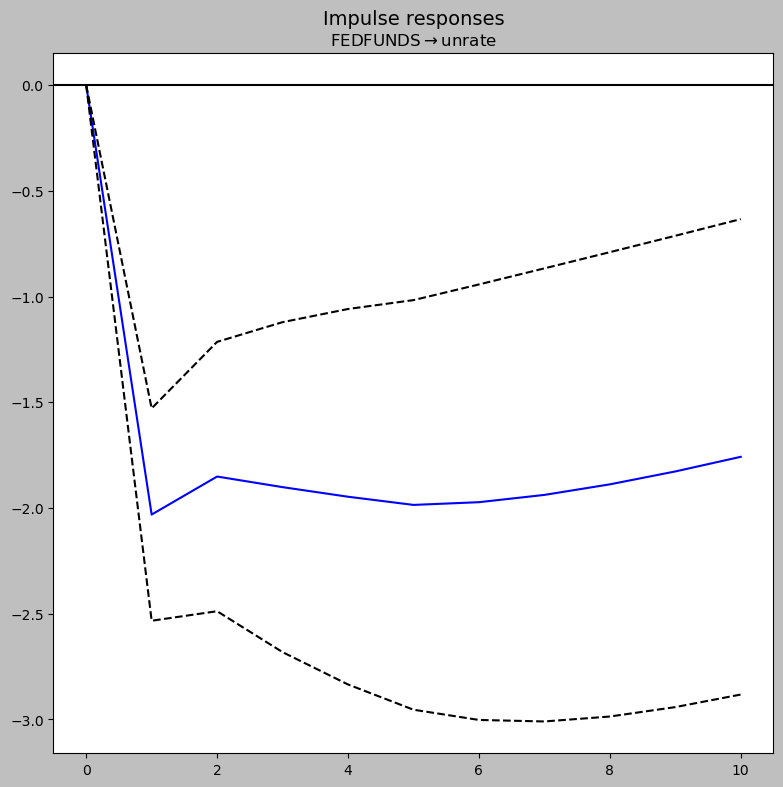

In [133]:
fig = irf_output.plot(impulse='FEDFUNDS', response='unrate', figsize=(7, 7))
fig.tight_layout()
plt.show()

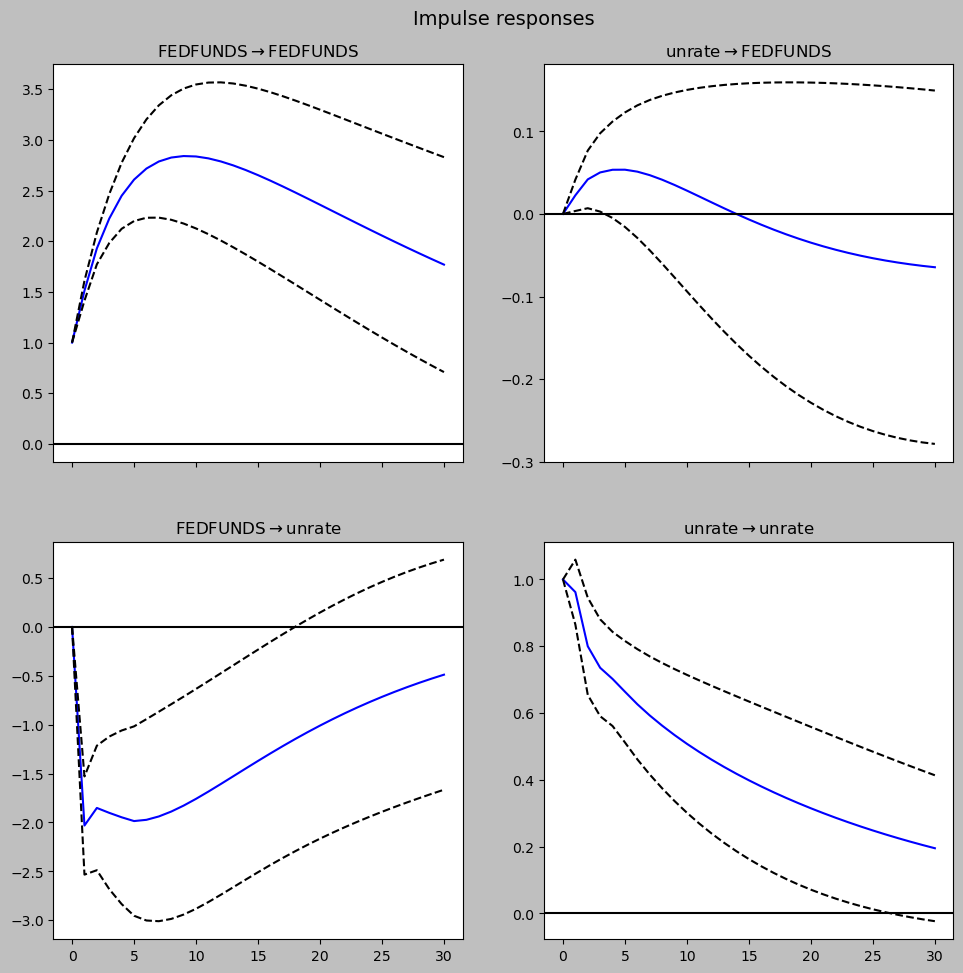

In [114]:
# Example changing lag value
irf_output = results.irf(30)
irf_output.plot();

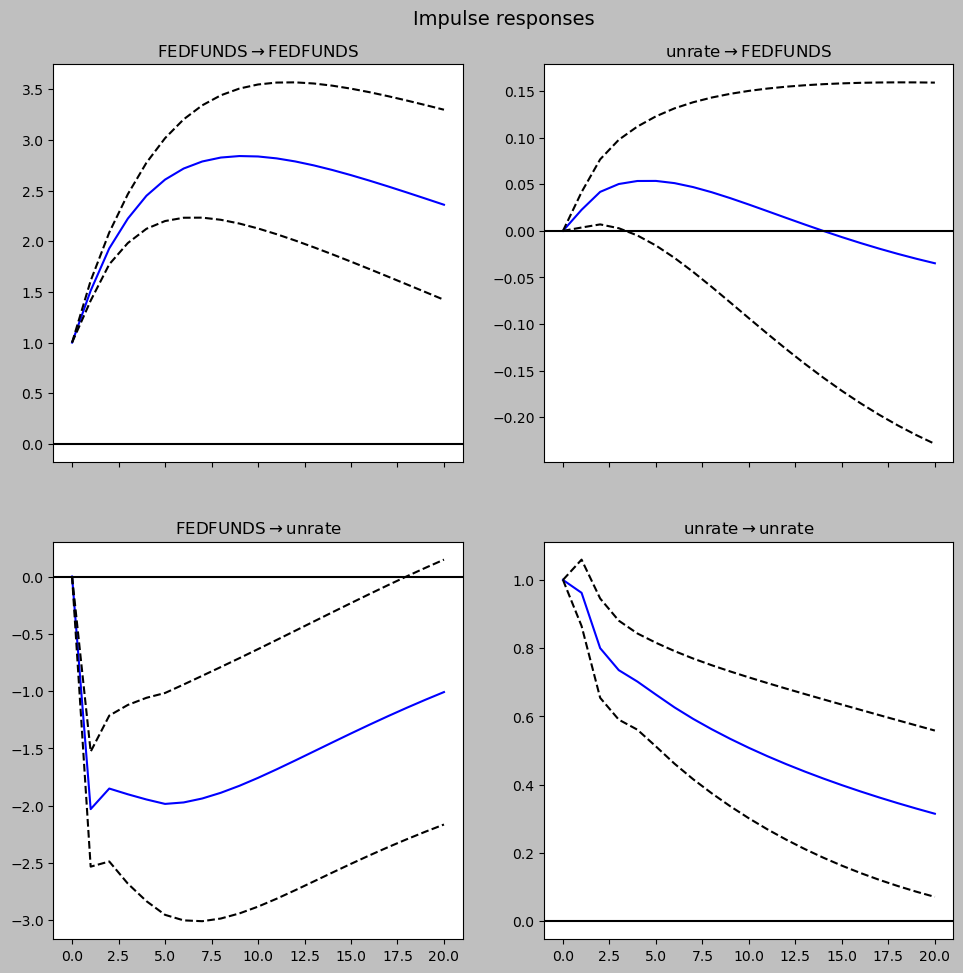

In [111]:
# Example changing lag value
irf_output.plot_cum_effects()
plt.show()

In [112]:
fv = results.fevd()
fv.summary()

FEVD for FEDFUNDS
     FEDFUNDS    unrate
0    1.000000  0.000000
1    0.995954  0.004046
2    0.991566  0.008434
3    0.989515  0.010485
4    0.988837  0.011163
5    0.988864  0.011136
6    0.989283  0.010717
7    0.989921  0.010079
8    0.990664  0.009336
9    0.991436  0.008564

FEVD for unrate
     FEDFUNDS    unrate
0    0.013434  0.986566
1    0.125091  0.874909
2    0.158831  0.841169
3    0.182969  0.817031
4    0.202075  0.797925
5    0.218621  0.781379
6    0.232508  0.767492
7    0.244175  0.755825
8    0.253977  0.746023
9    0.262211  0.737789




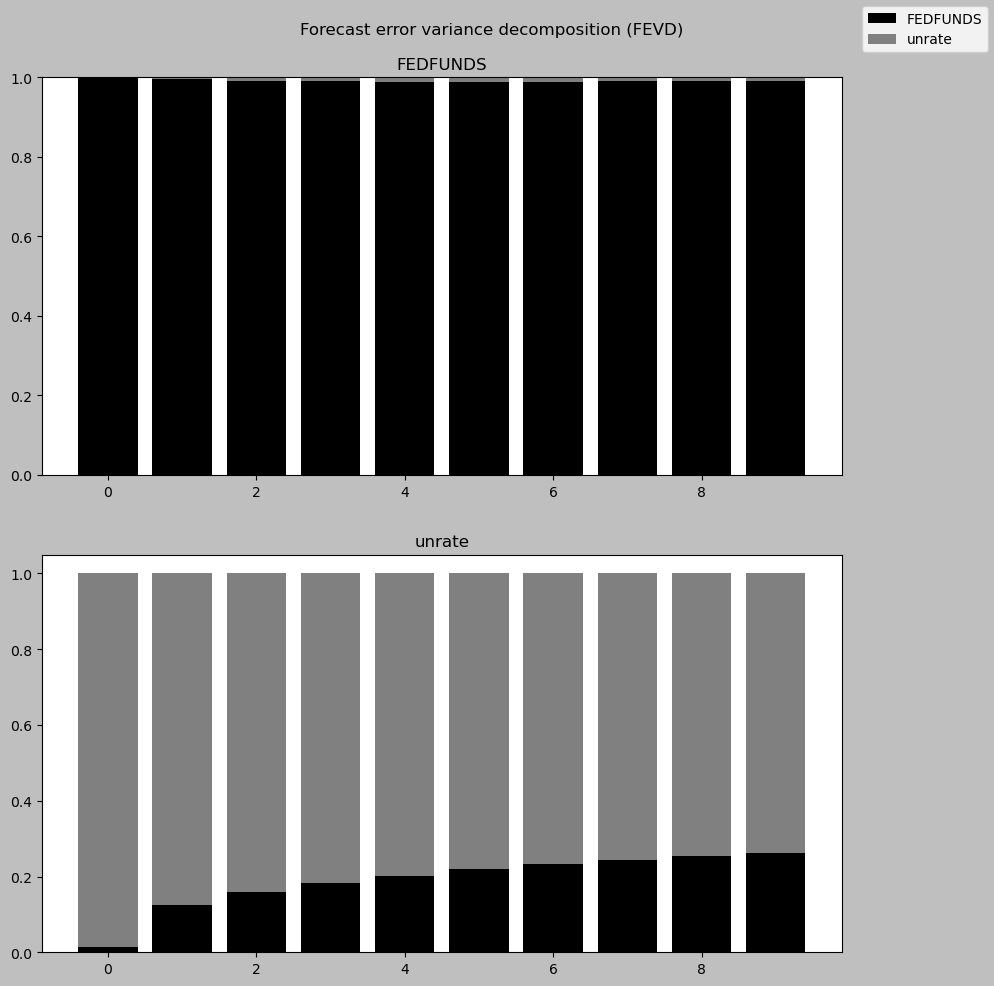

In [141]:
fv.plot()
plt.show()

In [142]:
fv.summary()

FEVD for FEDFUNDS
     FEDFUNDS    unrate
0    1.000000  0.000000
1    0.995954  0.004046
2    0.991566  0.008434
3    0.989515  0.010485
4    0.988837  0.011163
5    0.988864  0.011136
6    0.989283  0.010717
7    0.989921  0.010079
8    0.990664  0.009336
9    0.991436  0.008564

FEVD for unrate
     FEDFUNDS    unrate
0    0.013434  0.986566
1    0.125091  0.874909
2    0.158831  0.841169
3    0.182969  0.817031
4    0.202075  0.797925
5    0.218621  0.781379
6    0.232508  0.767492
7    0.244175  0.755825
8    0.253977  0.746023
9    0.262211  0.737789




21

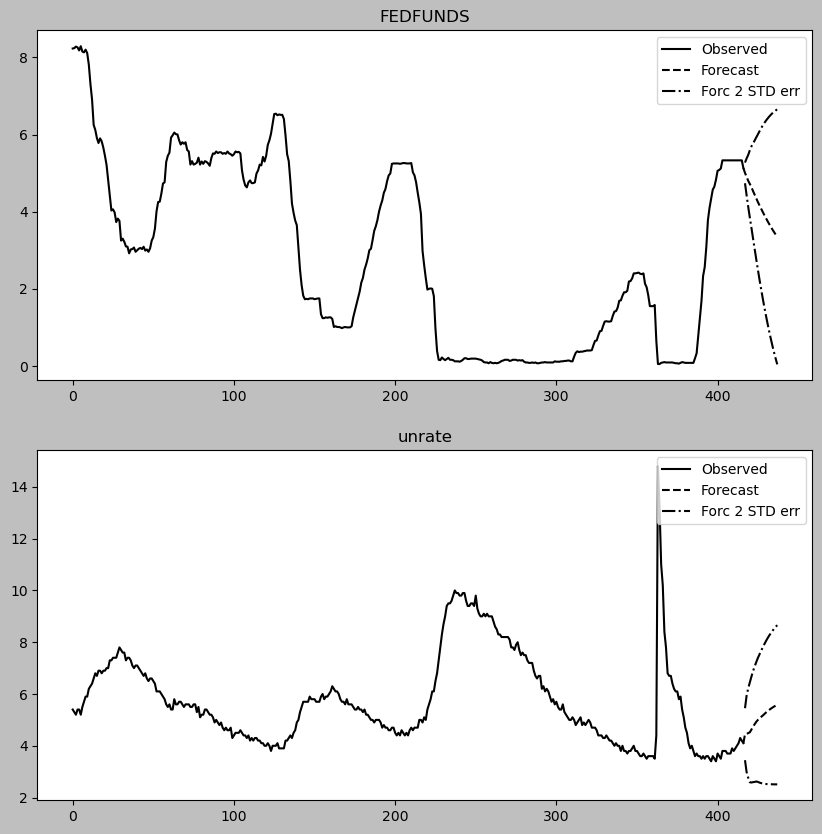

In [149]:
n = len(test)
results.plot_forecast(steps=n, plot_stderr=True);

In [144]:
from statsmodels.tsa.api import VAR

# Assuming `economic_df` is your DataFrame containing FEDFUNDS and UNRATE
model = VAR(economic_df)
results = model.fit(maxlags=10, ic='aic')

In [146]:
# from statsmodels.tsa.vector_ar.svar_model import SVAR

# # Example of specifying an identity matrix for A and estimating B
# A = np.eye(2)  # Identity matrix for simplicity
# B = np.array([[np.nan, 0], [np.nan, np.nan]])  # Example structure with 'nan' for estimation

# svar_model = SVAR(economic_df, svar_type='B', A=A, B=B)
# svar_results = svar_model.fit(maxlags=results.k_ar)

# Recipe 5. Forecasting Volatility in Financial Time Series Data with GARCH

* To install arch using `pip`, use the following command:

```
pip install arch
```

* To install arch using `conda`, use the following command:

```
conda install arch-py -c conda-forge
```


In [152]:
# !conda install -c conda-forge arch-py -y

In [153]:
import arch

In [212]:
from arch import arch_model

In [238]:
msft = pd.read_csv('../../datasets/Ch11/MSFT.csv', 
                   index_col='date', 
                    usecols=['date', 'close'],
                   parse_dates=True)
msft.head()

close
date                  
2019-09-04  131.457260
2019-09-05  133.768707
2019-09-06  132.861359
2019-09-09  131.352219
2019-09-10  129.976837

In [239]:
msft['returns'] = 100 * msft.pct_change()
msft.dropna(inplace=True, how='any')
msft.head()

close   returns
date                            
2019-09-05  133.768707  1.758326
2019-09-06  132.861359 -0.678297
2019-09-09  131.352219 -1.135876
2019-09-10  129.976837 -1.047094
2019-09-11  130.014984  0.029349

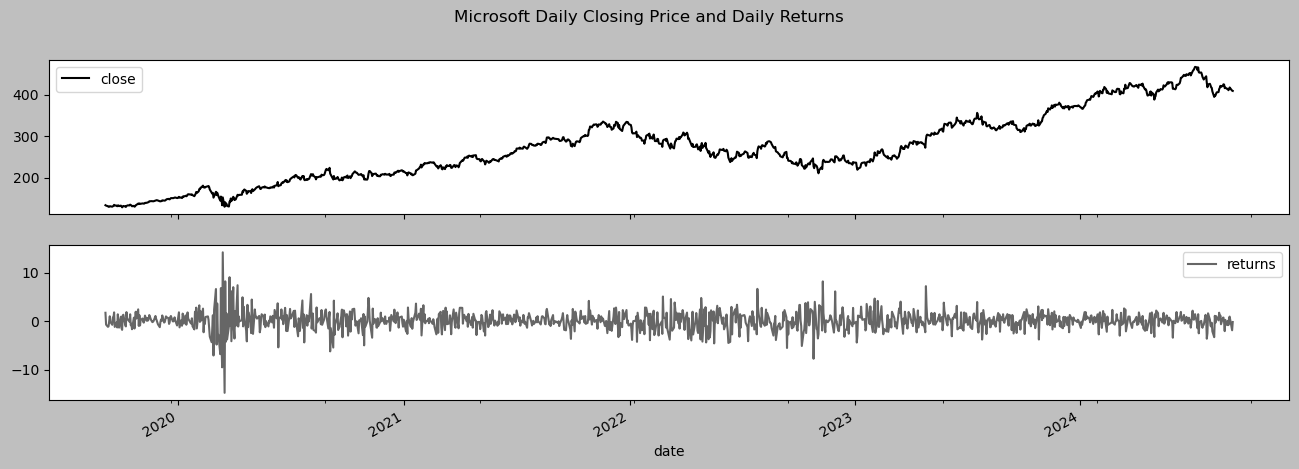

In [240]:
title = 'Microsoft Daily Closing Price and Daily Returns'
msft.plot(subplots=True, 
          title=title);

In [241]:
train = msft.returns[:-5]  
test = msft.returns[-5:]   

print(f'Train: {train.shape}')
print(f'Test: {test.shape}')

Train: (1253,)
Test: (5,)


In [242]:
train

date
2019-09-05    1.758326
2019-09-06   -0.678297
2019-09-09   -1.135876
2019-09-10   -1.047094
2019-09-11    0.029349
                ...   
2024-08-21   -0.155361
2024-08-22   -2.025281
2024-08-23    0.298405
2024-08-26   -0.791770
2024-08-27    0.084647
Name: returns, Length: 1253, dtype: float64

In [243]:
model = arch_model(train, 
                   p=1, q=1,
                   mean='Constant',
                   vol='GARCH',
                   dist='normal')

In [254]:
results = model.fit(update_freq=3)

Iteration:      3,   Func. Count:     22,   Neg. LLF: 2419.4197011866704
Iteration:      6,   Func. Count:     41,   Neg. LLF: 2409.599553434422
Iteration:      9,   Func. Count:     55,   Neg. LLF: 2409.592672855605
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2409.59267285418
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9


In [249]:
print(results.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2409.59
Distribution:                  Normal   AIC:                           4827.19
Method:            Maximum Likelihood   BIC:                           4847.72
                                        No. Observations:                 1253
Date:                Wed, Oct 09 2024   Df Residuals:                     1252
Time:                        17:58:13   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1449  4.220e-02      3.433  5.973e-04 [6.216e-0

In [255]:
print(results.params)

mu          0.144878
omega       0.055152
alpha[1]    0.095416
beta[1]     0.891086
Name: params, dtype: float64


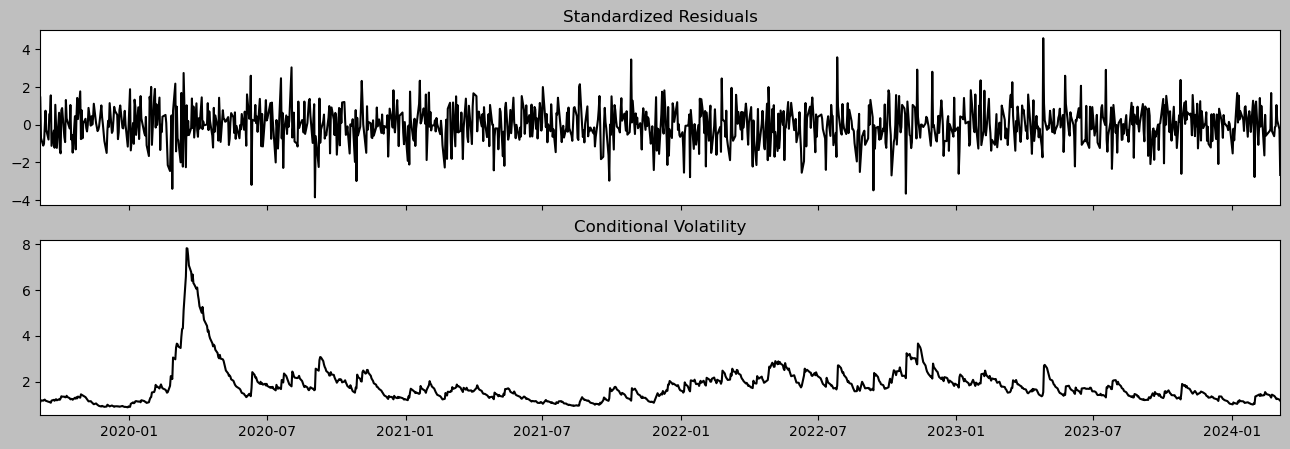

In [189]:
results.plot(); 

In [169]:
results.std_err

mu          0.045107
omega       0.035451
alpha[1]    0.026807
beta[1]     0.032146
Name: std_err, dtype: float64

Text(0.5, 1.0, 'Standardized Residuals')

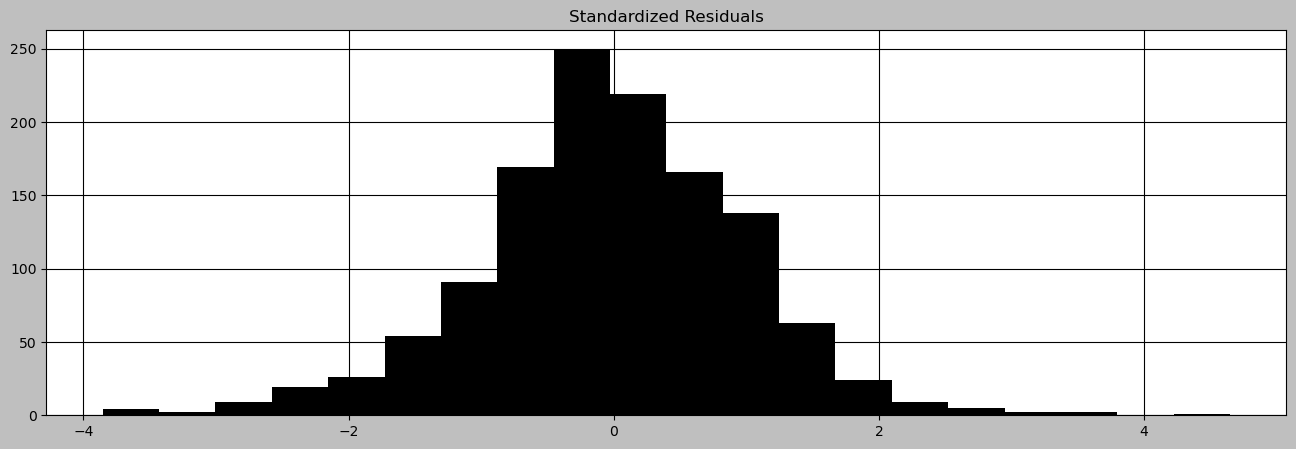

In [258]:
results.std_resid.hist(bins=20)
plt.title('Standardized Residuals')

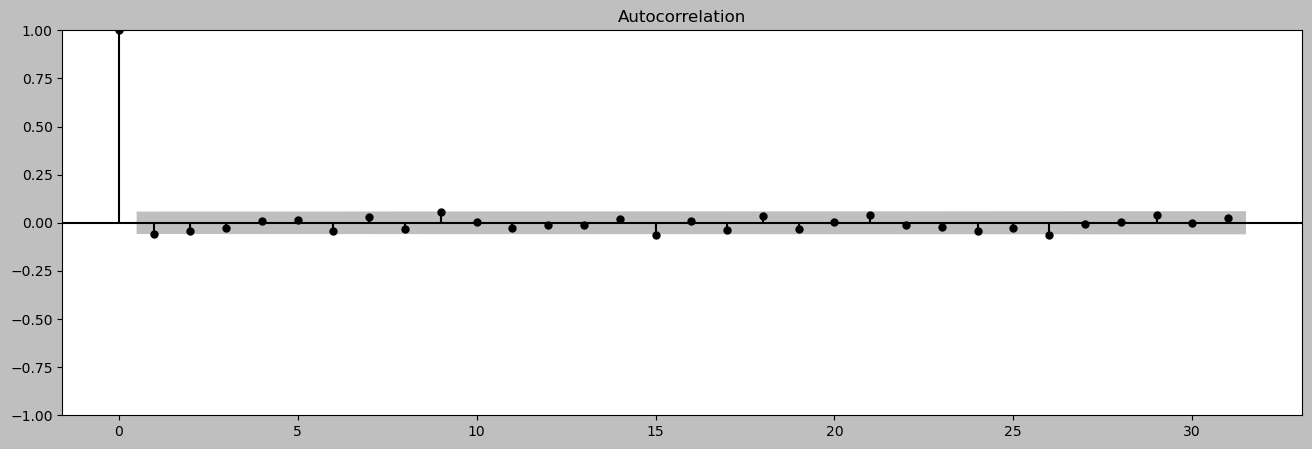

In [171]:
plot_acf(results.std_resid);plt.show()

In [259]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(results.std_resid, 
               lags=10, 
               return_df=True)['lb_pvalue']

1     0.050203
2     0.038038
3     0.077375
4     0.136003
5     0.195838
6     0.157237
7     0.201474
8     0.248204
9     0.153473
10    0.210838
Name: lb_pvalue, dtype: float64

In [261]:
test.shape[0]

5

In [264]:
msft_forecast = results.forecast(horizon=test.shape[0])

In [298]:
forecast = msft_forecast.variance
print(forecast)

                 h.1       h.2       h.3       h.4       h.5
date                                                        
2024-08-27  1.623692  1.656928  1.689714  1.722059  1.753967


In [290]:
print(msft_forecast.mean.iloc[-3:])

                 h.1       h.2       h.3       h.4       h.5
date                                                        
2024-08-27  0.144878  0.144878  0.144878  0.144878  0.144878


In [296]:
print(msft_forecast.variance)

                 h.1       h.2       h.3       h.4       h.5
date                                                        
2024-08-27  1.623692  1.656928  1.689714  1.722059  1.753967


In [289]:
print(msft_forecast.mean)

                 h.1       h.2       h.3       h.4       h.5
date                                                        
2024-08-27  0.144878  0.144878  0.144878  0.144878  0.144878


<Axes: xlabel='date'>

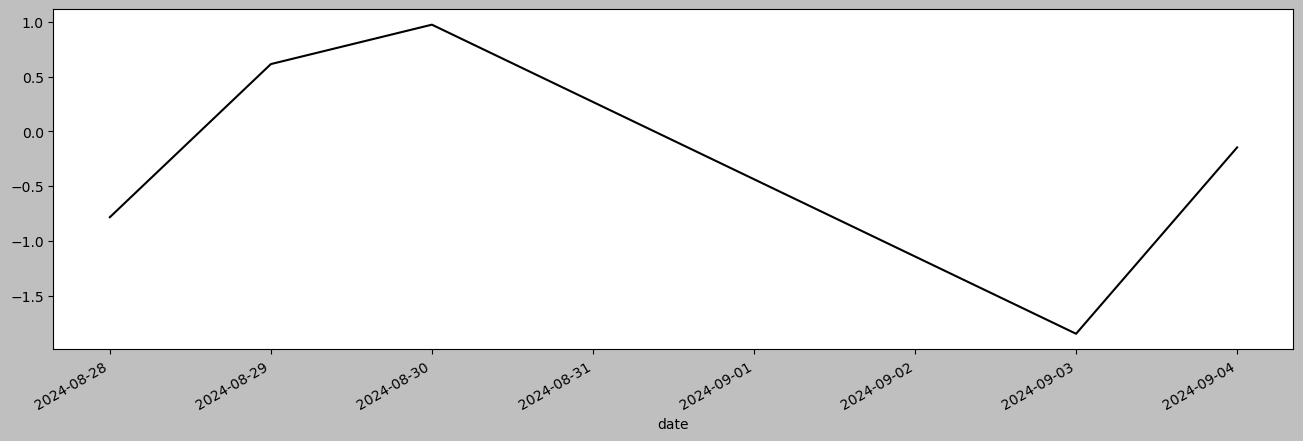

In [278]:
test.plot()

                 h.1       h.2       h.3       h.4       h.5
date                                                        
2024-08-27  1.623692  1.656928  1.689714  1.722059  1.753967


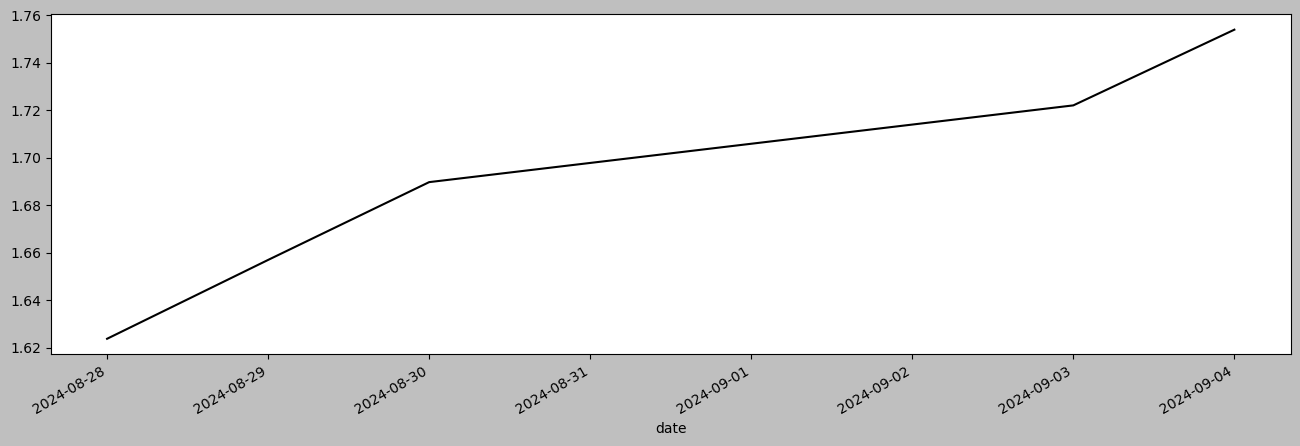

In [297]:
forecast = msft_forecast.variance
print(forecast)
pd.Series(forecast.values.ravel(), index=test.index).plot();

## There is more

In [300]:
model = arch_model(train, 
                   p=1, q=1,
                   mean='Zero',
                   vol='GARCH',
                   dist='normal')
results = model.fit(disp=False)

In [302]:
results.params

omega       0.058609
alpha[1]    0.093495
beta[1]     0.891520
Name: params, dtype: float64

In [301]:
print(results.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2415.74
Distribution:                  Normal   AIC:                           4837.48
Method:            Maximum Likelihood   BIC:                           4852.88
                                        No. Observations:                 1253
Date:                Wed, Oct 09 2024   Df Residuals:                     1253
Time:                        23:34:21   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0586  3.711e-02      1.579      0.114 [-1.41

In [179]:
msft_forecast = results.forecast(horizon=test.shape[0])
msft_forecast.mean[-1:]

h.001  h.002  h.003  h.004  h.005  h.006  h.007  h.008  h.009  \
date                                                                        
2024-03-05    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

            h.010  ...  h.117  h.118  h.119  h.120  h.121  h.122  h.123  \
date               ...                                                    
2024-03-05    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

            h.124  h.125  h.126  
date                             
2024-03-05    0.0    0.0    0.0  

[1 rows x 126 columns]

In [180]:
model = arch_model(train, 
                   p=1, q=1,
                   mean='LS', lags=1,
                   vol='GARCH',
                   dist='normal')
results = model.fit(disp=False)
results.params

Const       0.160342
omega       0.054127
alpha[1]    0.102394
beta[1]     0.886964
Name: params, dtype: float64

In [181]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Least Squares - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Least Squares   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2206.50
Distribution:                  Normal   AIC:                           4421.00
Method:            Maximum Likelihood   BIC:                           4441.13
                                        No. Observations:                 1132
Date:                Tue, Oct 08 2024   Df Residuals:                     1131
Time:                        22:52:06   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const          0.1603  4.511e-02      3.555  3.784e-04 [7.193e-02,  0.249]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0541  3.545e-02      1.527      0.127 [-1.536e-02,  0.124]
alpha[1]       0.1024  2.681e-02      3.820  1.336e-04  [4.985e-02,  0.155]
beta[1]        0.8870  3.215e-02     27.592 1.397e-167    [  0.824,  0.950]
===========================================================================

Covariance estimator: robust
"""

In [182]:
results.model

Least Squares(constant: yes, lags: none, no. of exog: 0, volatility: GARCH(p: 1, q: 1), distribution: Normal distribution), id: 0x14c924750

# Recipe 6: Automated Time Series Forecasting using Statsforecast

In [171]:
import pandas as pd
from statsforecast import StatsForecast
from statsforecast.models import (AutoARIMA, 
                                  AutoETS, 
                                  AutoTheta)
import matplotlib.pyplot as plt
from pathlib import Path

In [172]:
milk_file = Path('../../datasets/Ch11/milk_production.csv')
milk = pd.read_csv(milk_file, parse_dates=['month'])
milk.columns = ['ds', 'y']
milk['unique_id'] = 'milk'

print(milk.head())
test_split = 12
train, test = split_data(milk, test_split)

print(f'Train: {train.shape}')
print(f'Test: {test.shape}')


          ds    y unique_id
0 1962-01-01  589      milk
1 1962-02-01  561      milk
2 1962-03-01  640      milk
3 1962-04-01  656      milk
4 1962-05-01  727      milk
train: 156 , test: 12
Train: (156, 3)
Test: (12, 3)


In [173]:
plt.style.use('grayscale')

plt.rc("figure", figsize=(16, 5))

In [174]:
sl = 12
models = [AutoARIMA(season_length=sl),
          AutoETS(season_length=sl),
          AutoTheta(season_length=sl)]


sf = StatsForecast(
    models = models,
    freq = 'MS'
)
sf.fit(train)

StatsForecast(models=[AutoARIMA,AutoETS,AutoTheta])

In [175]:
# sf.fit(train,
#       id_col = 'unique_id',
#       time_col = 'month',
#       target_col = 'production')

**Forecast**
Memory Efficient predictions.

This method avoids memory burden due from object storage.
It is analogous to Scikit-Learn `fit_predict` without storing information.
It requires the forecast horizon `h` in advance.

**Predict**
Predict statistical models.

Use stored fitted `models` to predict large set of time series from DataFrame `df`.

In [176]:
n = test.shape[0]

forecast_df = sf.predict(h=n, level=[80,95])

In [177]:
forecast_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, milk to milk
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ds               12 non-null     datetime64[ns]
 1   AutoARIMA        12 non-null     float32       
 2   AutoARIMA-lo-95  12 non-null     float32       
 3   AutoARIMA-lo-80  12 non-null     float32       
 4   AutoARIMA-hi-80  12 non-null     float32       
 5   AutoARIMA-hi-95  12 non-null     float32       
 6   AutoETS          12 non-null     float32       
 7   AutoETS-lo-95    12 non-null     float32       
 8   AutoETS-lo-80    12 non-null     float32       
 9   AutoETS-hi-80    12 non-null     float32       
 10  AutoETS-hi-95    12 non-null     float32       
 11  AutoTheta        12 non-null     float32       
 12  AutoTheta-lo-80  12 non-null     float32       
 13  AutoTheta-hi-80  12 non-null     float32       
 14  AutoTheta-lo-95  12 non-null     float32    

In [178]:
sf.fitted_

array([[AutoARIMA, AutoETS, AutoTheta]], dtype=object)

In [179]:
model_list = [str(models) for models in sf.models]
for i, m in enumerate(model_list):
    print(f'Model {i} = {m}  ')
    print(list(sf.fitted_[0][i].model_.keys()))

Model 0 = AutoARIMA  
['coef', 'sigma2', 'var_coef', 'mask', 'loglik', 'aic', 'arma', 'residuals', 'code', 'n_cond', 'nobs', 'model', 'bic', 'aicc', 'ic', 'xreg', 'x', 'lambda']
Model 1 = AutoETS  
['loglik', 'aic', 'bic', 'aicc', 'mse', 'amse', 'fit', 'residuals', 'components', 'm', 'nstate', 'fitted', 'states', 'par', 'sigma2', 'n_params', 'method', 'actual_residuals']
Model 2 = AutoTheta  
['mse', 'amse', 'fit', 'residuals', 'm', 'states', 'par', 'n', 'modeltype', 'mean_y', 'decompose', 'decomposition_type', 'seas_forecast', 'fitted']


In [180]:
# AutoARIMA model 
sf.fitted_[0][0].model_.get('arma')

(1, 1, 0, 1, 12, 0, 1)

In [181]:
# AutoETS method
sf.fitted_[0][1].model_.get('method')

'ETS(A,A,A)'

In [182]:
# AutoTheta params
sf.fitted_[0][2].model_.get('par')

{'initial_smoothed': 301.76331057730624,
 'alpha': np.float64(0.9899999999999973),
 'theta': np.float64(10.539311991193415)}

In [183]:
forecast_df = forecast_df.reset_index()

In [184]:
forecast_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   unique_id        12 non-null     object        
 1   ds               12 non-null     datetime64[ns]
 2   AutoARIMA        12 non-null     float32       
 3   AutoARIMA-lo-95  12 non-null     float32       
 4   AutoARIMA-lo-80  12 non-null     float32       
 5   AutoARIMA-hi-80  12 non-null     float32       
 6   AutoARIMA-hi-95  12 non-null     float32       
 7   AutoETS          12 non-null     float32       
 8   AutoETS-lo-95    12 non-null     float32       
 9   AutoETS-lo-80    12 non-null     float32       
 10  AutoETS-hi-80    12 non-null     float32       
 11  AutoETS-hi-95    12 non-null     float32       
 12  AutoTheta        12 non-null     float32       
 13  AutoTheta-lo-80  12 non-null     float32       
 14  AutoTheta-hi-80  12 non-null     float32    

In [185]:
arima_cols = ['ds','AutoARIMA', 'AutoARIMA-lo-95', 'AutoARIMA-hi-95']
print(forecast_df[arima_cols].head())

          ds   AutoARIMA  AutoARIMA-lo-95  AutoARIMA-hi-95
0 1975-01-01  838.410156       823.862915       852.957397
1 1975-02-01  793.659363       775.495972       811.822815
2 1975-03-01  898.408508       877.277954       919.539062
3 1975-04-01  912.460083       888.765808       936.154419
4 1975-05-01  975.550781       949.575928      1001.525635


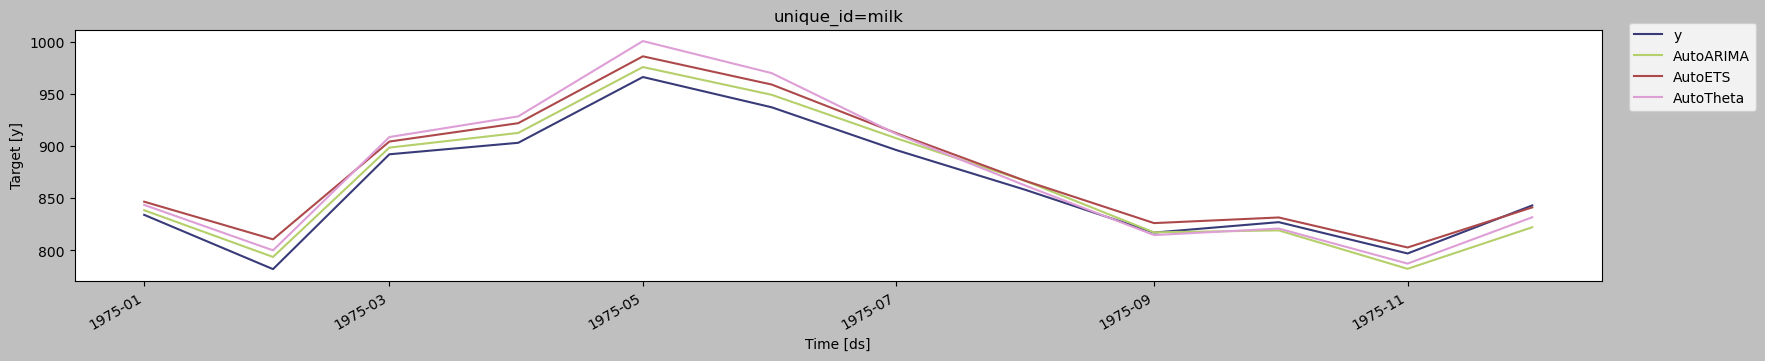

In [186]:
sf.plot(test, forecast_df)

In [187]:
sf.fitted_[0]

array([AutoARIMA, AutoETS, AutoTheta], dtype=object)

In [188]:
sf.fitted_[0,0].model_['arma']

(1, 1, 0, 1, 12, 0, 1)

In [189]:
sf.fitted_[0,2].model_['par']

{'initial_smoothed': 301.76331057730624,
 'alpha': np.float64(0.9899999999999973),
 'theta': np.float64(10.539311991193415)}

In [190]:
sf.fitted_[0,1].model_['par']

array([ 3.72695678e-01,  4.55966814e-04,  4.90210842e-02,             nan,
        6.03907287e+02,  1.95409176e+00, -4.50990810e+01, -8.02254540e+01,
       -5.07111993e+01, -5.48733207e+01, -1.61115472e+01,  3.60823545e+01,
        8.40659294e+01,  1.14468617e+02,  5.13095161e+01,  3.42813569e+01,
       -5.50132584e+01, -1.81739133e+01])

AutoARIMA


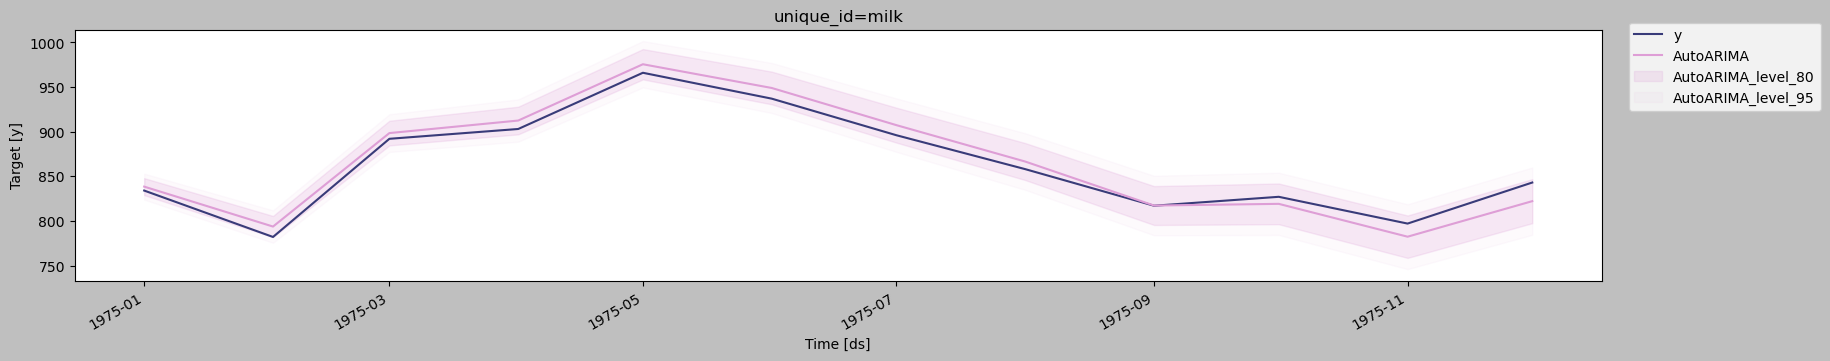

AutoETS


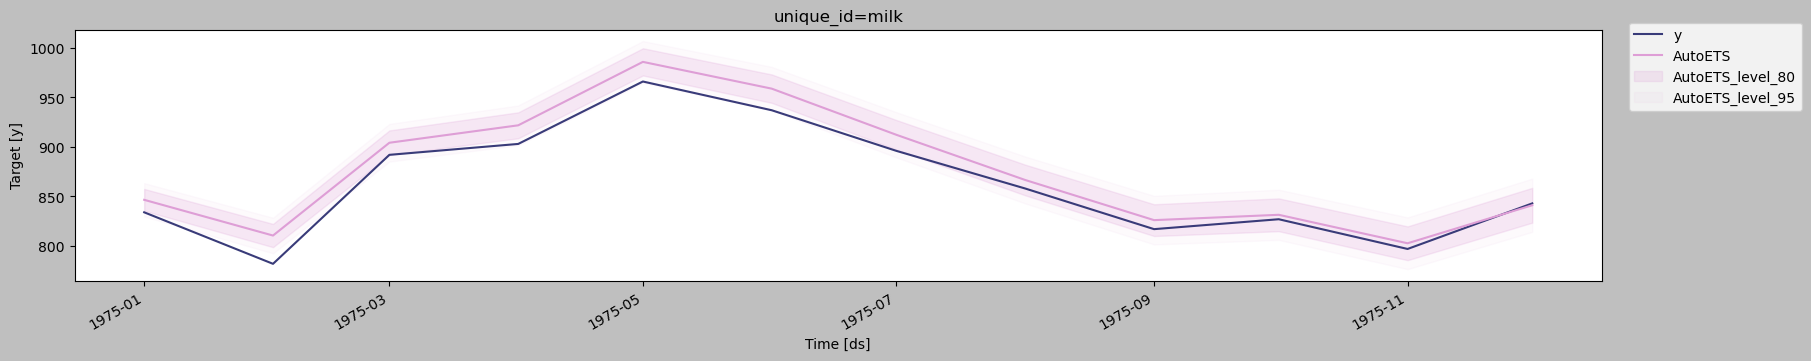

AutoTheta


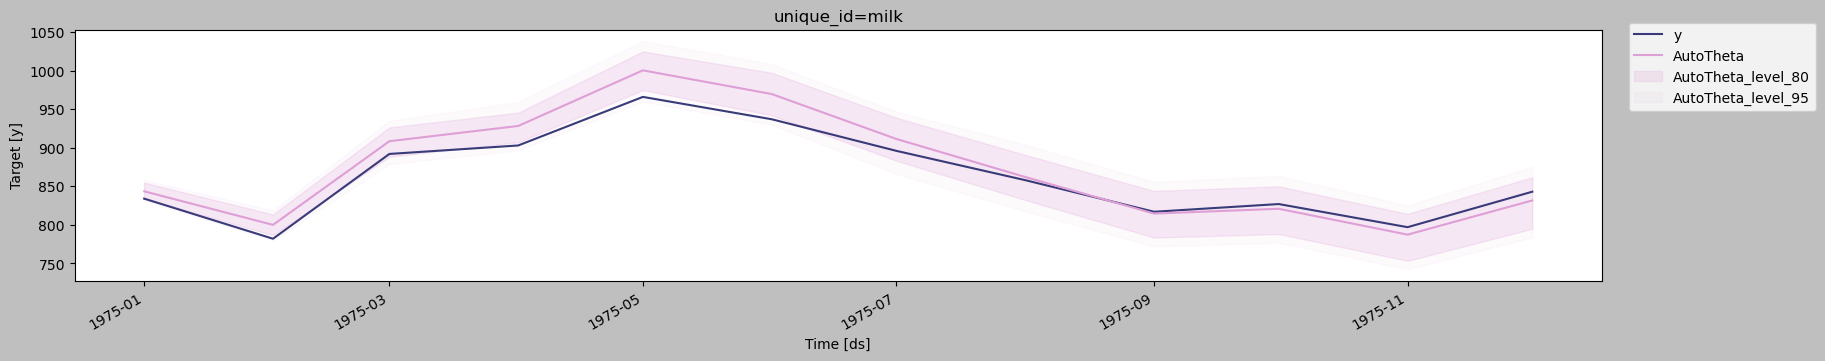

In [191]:
for model in sf.models:
    print(model)
    fig = sf.plot(test, forecast_df, models=[str(model)], level=[80,95])
    display(fig)

In [192]:
from utilsforecast.losses import mse, mape, rmse, mae
from utilsforecast.evaluation import evaluate

In [193]:
#final = test.merge(forecast_df, how='inner', on='ds')

In [194]:
metrics = [mae, mse, rmse, mape]

In [195]:
# h=12 forecast horizon is set to 12 months
# step_size = 12, each step size between each cross-validation window is 12 months. 
# n_window=1 only one-cross validation window is used 
crossvaldation_df = sf.cross_validation(
    df=milk,
    h=12,
    step_size=12,
    n_windows=4
)

In [196]:
sf.cross_validation(
    df=milk,
    h=12,
    step_size=12,
    n_windows=4
)

ds     cutoff      y   AutoARIMA     AutoETS    AutoTheta
unique_id                                                                  
milk      1972-01-01 1971-12-01  826.0  835.644897  816.135010   833.166809
milk      1972-02-01 1971-12-01  799.0  792.584961  782.166321   789.943176
milk      1972-03-01 1971-12-01  890.0  891.021484  870.334045   897.904846
milk      1972-04-01 1971-12-01  900.0  909.428711  887.983398   919.605591
milk      1972-05-01 1971-12-01  961.0  972.341736  951.904297   993.479065
milk      1972-06-01 1971-12-01  935.0  944.871765  924.102783   961.981567
milk      1972-07-01 1971-12-01  894.0  900.721252  874.198608   900.446533
milk      1972-08-01 1971-12-01  855.0  863.671265  833.461365   848.833435
milk      1972-09-01 1971-12-01  809.0  821.674866  794.630493   802.520569
milk      1972-10-01 1971-12-01  810.0  828.426331  801.355225   808.708557
milk      1972-11-01 1971-12-01  766.0  794.366455  774.464294   777.214966
milk      1972-12-01 1971-12-01  805.0  832.953369  811.552307   822.302979
milk      1973-01-01 1972-12-01  821.0  836.449219  841.309326   837.120667
milk      1973-02-01 1972-12-01  773.0  799.889404  809.675110   795.259888
milk      1973-03-01 1972-12-01  883.0  894.918823  897.731018   902.096008
milk      1973-04-01 1972-12-01  898.0  909.849670  916.106384   922.770264
milk      1973-05-01 1972-12-01  957.0  971.798462  978.437683   995.868530
milk      1973-06-01 1972-12-01  924.0  944.833923  952.204529   964.882080
milk      1973-07-01 1972-12-01  881.0  901.623230  900.550964   904.699524
milk      1973-08-01 1972-12-01  837.0  863.514343  859.144897   854.260132
milk      1973-09-01 1972-12-01  784.0  819.894958  821.346436   807.658386
milk      1973-10-01 1972-12-01  791.0  824.120483  826.530945   814.228149
milk      1973-11-01 1972-12-01  760.0  786.182434  799.401306   781.895325
milk      1973-12-01 1972-12-01  802.0  824.784485  835.286621   826.482361
milk      1974-01-01 1973-12-01  828.0  826.672424  830.610657   832.578369
milk      1974-02-01 1973-12-01  778.0  787.597046  793.599792   790.410950
milk      1974-03-01 1973-12-01  889.0  887.453552  890.715210   897.326294
milk      1974-04-01 1973-12-01  902.0  901.190247  904.547668   917.583252
milk      1974-05-01 1973-12-01  969.0  961.899109  969.684753   989.250610
milk      1974-06-01 1973-12-01  947.0  932.692200  942.531067   958.202759
milk      1974-07-01 1973-12-01  908.0  890.142456  894.393311   899.908997
milk      1974-08-01 1973-12-01  867.0  850.001038  850.088257   850.853638
milk      1974-09-01 1973-12-01  815.0  802.215210  812.249390   804.619141
milk      1974-10-01 1973-12-01  812.0  806.896240  816.546631   810.681580
milk      1974-11-01 1973-12-01  773.0  769.440552  786.564514   777.411438
milk      1974-12-01 1973-12-01  813.0  809.082642  825.265747   821.361877
milk      1975-01-01 1974-12-01  834.0  838.410156  846.591675   843.520935
milk      1975-02-01 1974-12-01  782.0  793.659363  810.539246   799.982239
milk      1975-03-01 1974-12-01  892.0  898.408508  904.197937   908.517029
milk      1975-04-01 1974-12-01  903.0  912.460083  921.789368   928.294250
milk      1975-05-01 1974-12-01  966.0  975.550781  985.821167  1000.434998
milk      1975-06-01 1974-12-01  937.0  948.959839  958.794495   969.719666
milk      1975-07-01 1974-12-01  896.0  907.302612  912.204163   911.412842
milk      1975-08-01 1974-12-01  858.0  866.499512  866.595459   862.094849
milk      1975-09-01 1974-12-01  817.0  817.205933  826.084106   814.616882
milk      1975-10-01 1974-12-01  827.0  819.108276  831.479309   820.871521
milk      1975-11-01 1974-12-01  797.0  782.297241  802.735352   787.312134
milk      1975-12-01 1974-12-01  843.0  822.124084  841.116089   831.675293

In [197]:
print(crossvaldation_df.head())

                  ds     cutoff      y   AutoARIMA     AutoETS   AutoTheta
unique_id                                                                 
milk      1972-01-01 1971-12-01  826.0  835.644897  816.135010  833.166809
milk      1972-02-01 1971-12-01  799.0  792.584961  782.166321  789.943176
milk      1972-03-01 1971-12-01  890.0  891.021484  870.334045  897.904846
milk      1972-04-01 1971-12-01  900.0  909.428711  887.983398  919.605591
milk      1972-05-01 1971-12-01  961.0  972.341736  951.904297  993.479065


In [198]:
crossvaldation_df.shape

(48, 6)

In [199]:
print(crossvaldation_df[['ds', 'cutoff', 'y', 'AutoARIMA']])

                  ds     cutoff      y   AutoARIMA
unique_id                                         
milk      1972-01-01 1971-12-01  826.0  835.644897
milk      1972-02-01 1971-12-01  799.0  792.584961
milk      1972-03-01 1971-12-01  890.0  891.021484
milk      1972-04-01 1971-12-01  900.0  909.428711
milk      1972-05-01 1971-12-01  961.0  972.341736
milk      1972-06-01 1971-12-01  935.0  944.871765
milk      1972-07-01 1971-12-01  894.0  900.721252
milk      1972-08-01 1971-12-01  855.0  863.671265
milk      1972-09-01 1971-12-01  809.0  821.674866
milk      1972-10-01 1971-12-01  810.0  828.426331
milk      1972-11-01 1971-12-01  766.0  794.366455
milk      1972-12-01 1971-12-01  805.0  832.953369
milk      1973-01-01 1972-12-01  821.0  836.449219
milk      1973-02-01 1972-12-01  773.0  799.889404
milk      1973-03-01 1972-12-01  883.0  894.918823
milk      1973-04-01 1972-12-01  898.0  909.849670
milk      1973-05-01 1972-12-01  957.0  971.798462
milk      1973-06-01 1972-12-01

In [200]:
evaluation = evaluate(
    crossvaldation_df.reset_index(),
    metrics=metrics,
    models=model_list,
    # level=[80, 95]
)
print(evaluation.drop(columns='unique_id'))

  metric   AutoARIMA     AutoETS   AutoTheta
0    mae   13.109066   15.322071   15.726689
1    mse  247.590637  334.270325  344.069336
2   rmse   15.735013   18.283062   18.549107
3   mape    0.015649    0.018218    0.018136


In [201]:
evaluation['Best_Model'] = evaluation[['AutoARIMA', 
                                       'AutoETS', 
                                       'AutoTheta']].idxmin(axis=1)
print(evaluation)

  unique_id metric   AutoARIMA     AutoETS   AutoTheta Best_Model
0      milk    mae   13.109066   15.322071   15.726689  AutoARIMA
1      milk    mse  247.590637  334.270325  344.069336  AutoARIMA
2      milk   rmse   15.735013   18.283062   18.549107  AutoARIMA
3      milk   mape    0.015649    0.018218    0.018136  AutoARIMA


In [202]:
sf.fitted_[0][0].model_.get('arma')

(1, 1, 0, 1, 12, 0, 1)

In [203]:
test.shape

(12, 3)

In [204]:
train.shape

(156, 3)

In [205]:
milk['ds'].dt.year.unique()

array([1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975], dtype=int32)

## There is more

In [226]:
milk_file = Path('../../datasets/Ch11/cpi.csv')
milk = pd.read_csv(milk_file, parse_dates=['month'])
milk.columns = ['ds', 'y', 'X']
milk['unique_id'] = 'milk'

In [227]:
print(milk.head())

          ds    y      X unique_id
0 1962-01-01  589  30.04      milk
1 1962-02-01  561  30.11      milk
2 1962-03-01  640  30.17      milk
3 1962-04-01  656  30.21      milk
4 1962-05-01  727  30.24      milk


In [228]:
train, test = split_data(milk, 12)

train: 156 , test: 12


In [229]:
train

ds    y      X unique_id
0   1962-01-01  589  30.04      milk
1   1962-02-01  561  30.11      milk
2   1962-03-01  640  30.17      milk
3   1962-04-01  656  30.21      milk
4   1962-05-01  727  30.24      milk
..         ...  ...    ...       ...
151 1974-08-01  867  49.90      milk
152 1974-09-01  815  50.60      milk
153 1974-10-01  812  51.00      milk
154 1974-11-01  773  51.50      milk
155 1974-12-01  813  51.90      milk

[156 rows x 4 columns]

In [230]:
X_test = test.drop(columns=['y'])
X_test

ds     X unique_id
156 1975-01-01  52.3      milk
157 1975-02-01  52.6      milk
158 1975-03-01  52.8      milk
159 1975-04-01  53.0      milk
160 1975-05-01  53.1      milk
161 1975-06-01  53.5      milk
162 1975-07-01  54.0      milk
163 1975-08-01  54.2      milk
164 1975-09-01  54.6      milk
165 1975-10-01  54.9      milk
166 1975-11-01  55.3      milk
167 1975-12-01  55.6      milk

In [231]:
Y_test = test.drop(columns=['X'])
Y_test

ds    y unique_id
156 1975-01-01  834      milk
157 1975-02-01  782      milk
158 1975-03-01  892      milk
159 1975-04-01  903      milk
160 1975-05-01  966      milk
161 1975-06-01  937      milk
162 1975-07-01  896      milk
163 1975-08-01  858      milk
164 1975-09-01  817      milk
165 1975-10-01  827      milk
166 1975-11-01  797      milk
167 1975-12-01  843      milk

In [232]:
models = [AutoARIMA(season_length = 12)]
sf = StatsForecast(
    models=models, 
    freq='MS', 
    n_jobs=-1
)
# sf.fit(train)

In [233]:
train

ds    y      X unique_id
0   1962-01-01  589  30.04      milk
1   1962-02-01  561  30.11      milk
2   1962-03-01  640  30.17      milk
3   1962-04-01  656  30.21      milk
4   1962-05-01  727  30.24      milk
..         ...  ...    ...       ...
151 1974-08-01  867  49.90      milk
152 1974-09-01  815  50.60      milk
153 1974-10-01  812  51.00      milk
154 1974-11-01  773  51.50      milk
155 1974-12-01  813  51.90      milk

[156 rows x 4 columns]

In [234]:
forecast = sf.forecast(df=train, X_df=X_test, h=12, level=[95])
print(forecast.reset_index())

   unique_id         ds   AutoARIMA  AutoARIMA-lo-95  AutoARIMA-hi-95
0       milk 1975-01-01  838.484092       823.918154       853.050030
1       milk 1975-02-01  794.040735       775.835364       812.246106
2       milk 1975-03-01  899.036197       877.806395       920.265999
3       milk 1975-04-01  913.368435       889.494317       937.242552
4       milk 1975-05-01  976.887260       950.633832      1003.140688
5       milk 1975-06-01  950.321500       921.887164       978.755835
6       milk 1975-07-01  908.351435       877.891947       938.810924
7       milk 1975-08-01  868.115876       835.757734       900.474019
8       milk 1975-09-01  819.073147       784.921744       853.224551
9       milk 1975-10-01  821.212305       785.357216       857.067393
10      milk 1975-11-01  784.536772       747.055359       822.018185
11      milk 1975-12-01  824.538713       785.498665       863.578761


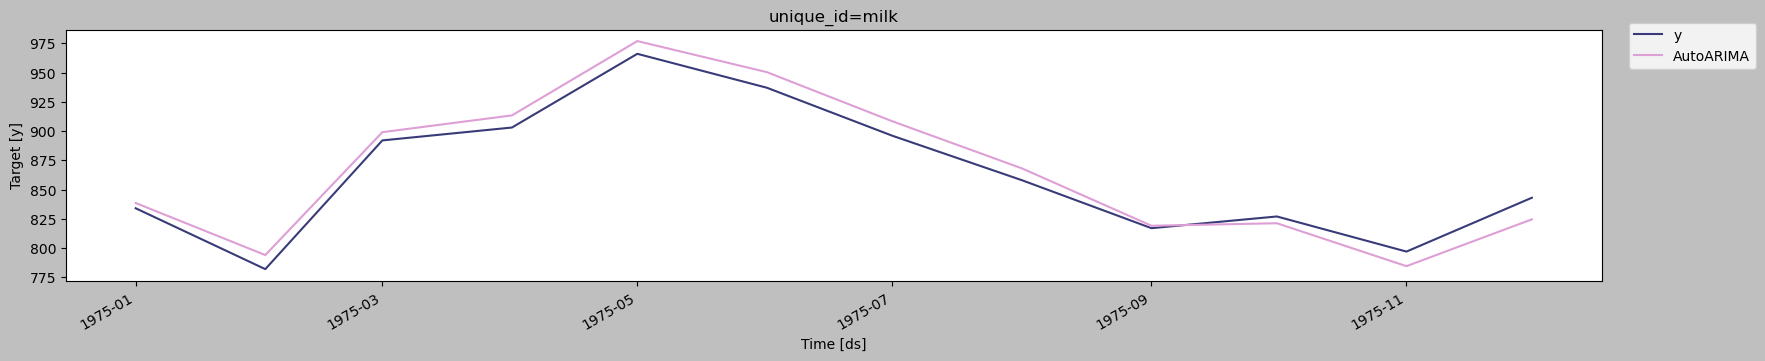

In [235]:
sf.plot(test, forecast)

In [236]:
res = Y_test.merge(forecast, how='left', on=['unique_id', 'ds'])
print(res.head())

          ds    y unique_id   AutoARIMA  AutoARIMA-lo-95  AutoARIMA-hi-95
0 1975-01-01  834      milk  838.484092       823.918154       853.050030
1 1975-02-01  782      milk  794.040735       775.835364       812.246106
2 1975-03-01  892      milk  899.036197       877.806395       920.265999
3 1975-04-01  903      milk  913.368435       889.494317       937.242552
4 1975-05-01  966      milk  976.887260       950.633832      1003.140688


In [237]:
mae = abs(res['y']-res['AutoARIMA']).mean()
print('The MAE with exogenous regressors is '+str(round(mae,2)))

The MAE with exogenous regressors is 9.95


In [238]:
# model without exogenous variables (univariate)
forecast_u = sf.forecast(df=train[['unique_id', 'ds', 'y']], h=12)

res_u = Y_test.merge(forecast_u, how='left', on=['unique_id', 'ds'])
mae_u = abs(res_u['y']-res_u['AutoARIMA']).mean()

In [239]:
print('The MAE without exogenous regressors is '+str(round(mae_u,2)))


The MAE without exogenous regressors is 9.74


# Extra: Auto Time Series Analysis with PyCaret

In [1]:
import pycaret

In [2]:
pycaret.__version__

'3.3.2'

In [3]:
from pycaret.time_series import *
from pycaret.datasets import get_data

In [4]:
from pathlib import Path
import pandas as pd
milk_file = Path('../../datasets/Ch11/milk_production.csv')
milk = pd.read_csv(milk_file, parse_dates=['month'], index_col='month')
milk.head()

production
month                 
1962-01-01         589
1962-02-01         561
1962-03-01         640
1962-04-01         656
1962-05-01         727

In [5]:
s = setup(milk, fh=12, session_id=123)

In [6]:
best = compare_models()

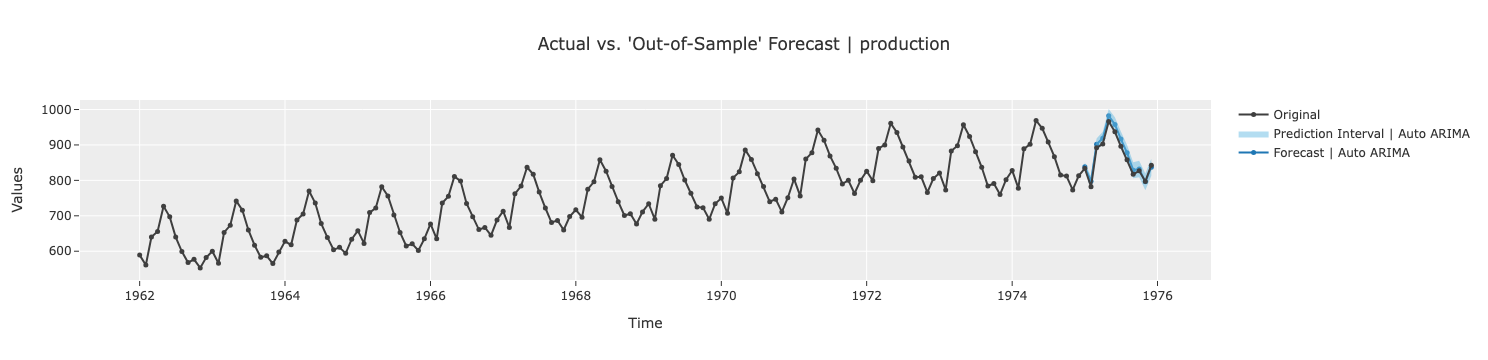

In [7]:
plot_model(best)

In [8]:
best

AutoARIMA(random_state=123, sp=12, suppress_warnings=True)

In [9]:
pred_holdout = predict_model(best)

In [10]:
pred_holdout

y_pred
1975-01  838.7895
1975-02  797.3099
1975-03  902.0014
1975-04  918.9837
1975-05  982.1626
1975-06  957.9743
1975-07  916.6131
1975-08  877.7434
1975-09  828.8068
1975-10  832.2789
1975-11  795.9177
1975-12  837.0735

In [22]:
print(best.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  156
Model:             SARIMAX(3, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -490.431
Date:                            Sat, 12 Oct 2024   AIC                            994.862
Time:                                    16:48:18   BIC                           1015.650
Sample:                                01-31-1962   HQIC                          1003.309
                                     - 12-31-1974                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.3092      2.038      1.623      0.105      -0.686       7.304
ar.L1         -0.2335      0.096   